In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pyDOE import lhs
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import MultiStepLR
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook
from time import time
import torch.optim as optim

### 参数设置

In [2]:
# 设置数据类型
DTYPE = torch.float64
# 定义问题参数
L = torch.tensor(2, dtype=DTYPE)  # 板的边长 (m)
E = torch.tensor(1, dtype=DTYPE)  # 杨氏模量 (Pa)<弹性模量>
nu = torch.tensor(0.3, dtype=DTYPE)  # 泊松比
a = torch.tensor(1, dtype=DTYPE) # 水平裂缝的长度 (m)
mu = E / (2 * (1 + nu))# 定义剪切模量G
lmda = E * nu / ((1 + nu) * (1 - 2 * nu)) #拉梅系数\lmda
kappa = 3 - 4 * nu #平面应变

P = torch.tensor(1, dtype=DTYPE)  # 上边界施加的拉应力 (Pa)

# Set boundary 设定边界
xmin = -1.
xmax = 1.
ymin = -3.
ymax = 3.
torch.set_default_dtype(DTYPE)
num_epochs = int(10000) #Adam训练步数
num_hidden = 8
num_nodes = 40
N_l = 1000 #LBFGS训练步数

#激活函数选择，顺序如下：
#nn.ReLU(),
#Swish(),
#nn.Tanh(),
#nn.Sigmoid(),
#nn.Softplus(), #平滑版本的 ReLU，公式为 f(x) = log(exp(x) + 1)
#nn.Softsign() #输出值在 -1 和 1 之间，公式为 f(x) = x / (1 + |x|)

ACT_function_1 = 2 #nn.Tanh()
ACT_function_2 = 1 #Swish()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Operation mode: ", device)

# 设置数据点
N_bound = 50  #每一边界上的数值点数
N_r = 2000    #内部的数值点数
N_r_J = 100    #在内部选为连接点的点数
N_crack = 200 #裂缝线上的数值点数
N_tip = 500 #裂尖附近的数值点数

Operation mode:  cpu


In [3]:

def calculate_k1(r):
    # 计算公式中的余弦部分
    cos_term = torch.cos(torch.pi * r / (2 * L))
    
    # 计算分子部分
    numerator = 1.46 + 3.42 * (1 - cos_term)
    
    # 计算分母部分
    denominator = torch.pow(cos_term, 2)
    
    # 计算整个表达式
    result = mu/(kappa+1) * torch.sqrt(torch.pi * 2 / r) * (4 * P * r * (1 - torch.pow(nu, 2)) / E) * (numerator / denominator)
    
    return result

# 裂纹尖端在 (0, 0)

def rr(x, y, tip_x=0, tip_y=0):
    # 计算从尖端到点 (x, y) 的距离
    return torch.sqrt((x - tip_x) ** 2 + (y - tip_y) ** 2)

def theta(x, y):
    # 计算极角
    #coord = torch.stack((x, y), dim=-1)  # 将 x 和 y 堆叠成一个 2xN 的矩阵
    return torch.atan2(y, x)  # 使用 torch.atan2 计算 arctan(y/x)，同时处理所有象限

def u_x_ext(x, y):
    if not torch.is_tensor(x):
        x = torch.from_numpy(x)
    if not torch.is_tensor(y):
        y = torch.from_numpy(y)
    r= rr(x, y)
    th= theta(x, y)
    utemp = calculate_k1(a)/(2*mu)*torch.sqrt(r/(2*torch.pi))* torch.cos(0.5 * th) *(kappa-1+2*(torch.sin(0.5 * th))**2)
    return utemp
def u_y_ext(x, y):
    if not torch.is_tensor(x):
        x = torch.from_numpy(x)
    if not torch.is_tensor(y):
        y = torch.from_numpy(y)
    r= rr(x, y)
    th= theta(x, y)
    utemp = calculate_k1(a)/(2*mu)*torch.sqrt(r/(2*torch.pi))* torch.sin(0.5 * th) *(kappa+1-2*(torch.cos(0.5 * th))**2)
    return utemp

def Sigmaxx_ext(x,y):
    if not torch.is_tensor(x):
        x = torch.from_numpy(x)
    if not torch.is_tensor(y):
        y = torch.from_numpy(y)
    r= rr(x, y)
    th= theta(x, y)
    gtemp = calculate_k1(a) / torch.sqrt(2 * torch.pi * r) * torch.cos(0.5 * th) * (1 - torch.sin(0.5 * th) * torch.sin(1.5 * th))
    return gtemp

def Sigmayy_ext(x,y):
    if not torch.is_tensor(x):
        x = torch.from_numpy(x)
    if not torch.is_tensor(y):
        y = torch.from_numpy(y)
    r= rr(x, y)
    th= theta(x, y)
    gtemp = calculate_k1(a) / torch.sqrt(2 * torch.pi * r) * torch.cos(0.5 * th) * (1 + torch.sin(0.5 * th) * torch.sin(1.5 * th))
    return gtemp

def Sigmaxy_ext(x,y):
    if not torch.is_tensor(x):
        x = torch.from_numpy(x)
    if not torch.is_tensor(y):
        y = torch.from_numpy(y)
    r= rr(x, y)
    th= theta(x, y)
    gtemp = calculate_k1(a) / torch.sqrt(2 * torch.pi * r) * torch.cos(0.5 * th) * torch.sin(0.5 * th) * torch.cos(1.5 * th)
    return gtemp

def f_x_ext(x, y):
    return 0

def f_y_ext(x, y):
    return 0


In [4]:
def getBoundary_points(xmin,xmax,ymin,ymax,DTYPE,N_bound,N_crack):
    # Lower bounds
    lb = torch.tensor([xmin, ymin], dtype=DTYPE)
    # Upper bounds
    ub = torch.tensor([xmax, ymax], dtype=DTYPE)

    # Set random seed for reproducible results 随机数种子
    torch.manual_seed(666)

    ###########################################################################
    # Boundary points
    x_up = lhs(1,samples=N_bound)
    x_up = xmin + (xmax-xmin)*x_up
    y_up = np.empty(len(x_up))[:,None]
    y_up.fill(ymax)
    b_up = np.empty([len(x_up),2])
    b_up[:,0,None] = np.asarray(u_x_ext(x_up, y_up))
    b_up[:,1,None] = np.asarray(u_y_ext(x_up, y_up))
    x_up_train = np.hstack((x_up, y_up))###上边界配点

    ux_up_train = b_up[:,0, None]
    uy_up_train = b_up[:,1, None]
    #ux_up_train = np.zeros([len(x_up),1])###上边界x位移
    Sxx_up_train = Sigmaxx_ext(x_up, y_up)
    Syy_up_train = Sigmayy_ext(x_up, y_up)
    Sxy_up_train = Sigmaxy_ext(x_up, y_up)
    #print(Syy_up_train)
    #Syy_up_train = fun_top_yy(x_up, y_up)###上边界应力条件
    

    x_up_train = torch.Tensor(x_up_train)
    ux_up_train = torch.Tensor(ux_up_train)
    uy_up_train = torch.Tensor(uy_up_train)
    Sxx_up_train = torch.Tensor(Sxx_up_train)
    Syy_up_train = torch.Tensor(Syy_up_train)
    Sxy_up_train = torch.Tensor(Sxy_up_train)

    x_lo = lhs(1,samples=N_bound)
    x_lo = xmin + (xmax-xmin)*x_lo
    y_lo = np.empty(len(x_lo))[:,None]
    y_lo.fill(ymin)
    b_lo = np.empty([len(x_lo),2])
    b_lo[:,0, None] = np.asarray(u_x_ext(x_lo, y_lo))
    b_lo[:,1, None] = np.asarray(u_y_ext(x_lo, y_lo))
    x_lo_train = np.hstack((x_lo, y_lo))###下边界配点
    ux_lo_train = b_lo[:,0, None]
    uy_lo_train = b_lo[:,1, None]

    #ux_lo_train = np.zeros([len(x_lo),1])###下边界x位移
    #uy_lo_train = np.zeros([len(x_lo),1])###下边界y位移
    Sxx_lo_train = Sigmaxx_ext(x_lo, y_lo)
    Syy_lo_train = Sigmayy_ext(x_lo, y_lo)###下边界应力条件
    Sxy_lo_train = Sigmaxy_ext(x_lo, y_lo)
    #Syy_lo_train = fun_bot_yy(x_lo, y_lo)###下边界应力条件

    x_lo_train = torch.Tensor(x_lo_train)
    ux_lo_train = torch.Tensor(ux_lo_train)
    uy_lo_train = torch.Tensor(uy_lo_train)
    Sxx_lo_train = torch.Tensor(Sxx_lo_train)
    Syy_lo_train = torch.Tensor(Syy_lo_train)
    Sxy_lo_train = torch.Tensor(Sxy_lo_train)

    y_ri = lhs(1,samples=N_bound)
    y_ri = ymin + (ymax-ymin)*y_ri
    x_ri = np.empty(len(y_ri))[:,None]
    x_ri.fill(xmax)
    b_ri = np.empty([len(x_ri),2])
    b_ri[:,0, None] = np.asarray(u_x_ext(x_ri, y_ri))
    b_ri[:,1, None] = np.asarray(u_y_ext(x_ri, y_ri))
    x_ri_train = np.hstack((x_ri, y_ri)) ###右边界配点
    ux_ri_train = b_ri[:,0, None]
    uy_ri_train = b_ri[:,1, None]###右边界y位移
    #uy_ri_train = np.zeros([len(x_ri),1])###右边界y位移（固定支撑）
    Sxx_ri_train = Sigmaxx_ext(x_ri, y_ri)###右边界sxx应力
    Syy_ri_train = Sigmayy_ext(x_ri, y_ri)
    Sxy_ri_train = Sigmaxy_ext(x_ri, y_ri)
    #Sxx_ri_train = np.zeros([len(x_ri),1])###右边界sxx应力（固定支撑）

    x_ri_train = torch.Tensor(x_ri_train)
    ux_ri_train = torch.Tensor(ux_ri_train)
    uy_ri_train = torch.Tensor(uy_ri_train)
    Sxx_ri_train = torch.Tensor(Sxx_ri_train)
    Syy_ri_train = torch.Tensor(Syy_ri_train)
    Sxy_ri_train = torch.Tensor(Sxy_ri_train)

    y_le = lhs(1,samples=N_bound)
    y_le = ymin + (ymax-ymin)*y_le
    x_le = np.empty(len(y_le))[:,None]
    x_le.fill(xmin)
    b_le = np.empty([len(x_le),2])
    b_le[:,0, None] = np.asarray(u_x_ext(x_le, y_le))
    b_le[:,1, None] = np.asarray(u_y_ext(x_le, y_le))
    x_le_train = np.hstack((x_le, y_le))###左边界配点
    ux_le_train = b_le[:,0, None]
    uy_le_train = b_le[:,1, None]###左边界y位移
    #uy_le_train = np.zeros([len(x_le),1])###左边界y位移（固定支撑）
    Sxx_le_train = Sigmaxx_ext(x_le, y_le)###左边界sxx应力
    Syy_le_train = Sigmayy_ext(x_le, y_le)
    Sxy_le_train = Sigmaxy_ext(x_le, y_le)
    #Sxx_le_train = np.zeros([len(x_le),1])###左边界sxx应力（固定支撑）

    x_le_train = torch.Tensor(x_le_train)
    ux_le_train = torch.Tensor(ux_le_train)
    uy_le_train = torch.Tensor(uy_le_train)
    Sxx_le_train = torch.Tensor(Sxx_le_train)
    Syy_le_train = torch.Tensor(Syy_le_train)
    Sxy_le_train = torch.Tensor(Sxy_le_train)

    # crack bc points 
    x_crack = lhs(1,samples=N_crack)
    x_crack = xmin + ((xmax-xmin)*0.5)*x_crack
    y_crack = np.empty(len(x_crack))[:,None]
    y_crack.fill((xmax+xmin)*0.5)
    crack = np.empty([len(x_crack),2])
    crack[:,0,None] = np.asarray(u_x_ext(x_crack, y_crack))
    crack[:,1,None] = np.asarray(u_y_ext(x_crack, y_crack))
    crack_train = np.hstack((x_crack, y_crack))###裂缝配点

    #Sxx_crack_train = np.zeros([len(x_crack),1])###裂缝界应力条件
    Syy_crack_train = np.zeros([len(x_crack),1])###裂缝界应力条件
    #Sxy_crack_train = np.zeros([len(x_crack),1])###裂缝界应力条件

    crack_train = torch.Tensor(crack_train)
    #Sxx_crack_train = torch.Tensor(Sxx_crack_train)
    Syy_crack_train = torch.Tensor(Syy_crack_train)
    #Sxy_crack_train = torch.Tensor(Sxy_crack_train)

    X_b_train = torch.cat((x_up_train, x_lo_train, x_ri_train, x_le_train, crack_train), dim=0)

    X_train_list = [x_up_train, x_lo_train, x_ri_train, x_le_train, crack_train]

    ux_b_train = torch.cat((ux_up_train, ux_lo_train, ux_ri_train, ux_le_train), dim=0)
    uy_b_train = torch.cat((uy_up_train, uy_lo_train, uy_ri_train, uy_le_train), dim=0)
    Sxx_b_train = torch.cat((Sxx_up_train, Sxx_lo_train, Sxx_ri_train, Sxx_le_train), dim=0)
    Syy_b_train = torch.cat((Syy_up_train, Syy_lo_train, Syy_ri_train, Syy_le_train), dim=0)
    #Sxx_crack_train = Sxx_crack_train
    Syy_crack_train = Syy_crack_train
    #Sxy_crack_train = Sxy_crack_train

    #return X_b_train, X_train_list, ux_b_train, uy_b_train, Sxx_b_train, Syy_b_train, \
    #    Sxx_crack_train, Syy_crack_train, Sxy_crack_train
    return X_b_train, X_train_list, ux_b_train, uy_b_train, Sxx_b_train, Syy_b_train, \
         Syy_crack_train

In [ ]:
def getCollocation_points_m(xmin,xmax,ymin,ymax,N_r,N_r_J,N_tip):
    #########################################################################
    # collocation points for PINNs
    # 使用拉丁超立方抽样（Latin Hypercube Sampling, LHS）生成的一组用于PINNs的配置点（collocation points）。
    # 使用 lhs 函数生成一个包含 N_r-N_r_J-N_tip 行和2列的数组，每一行代表一个二维空间中的点
    grid_pt = lhs(2,N_r-N_r_J-N_tip)
    grid_pt[:,0] = xmin + (xmax-xmin)*grid_pt[:,0] # 将第一列的每个点从 [0, 1] 区间线性映射到 [xmin, xmax] 区间
    grid_pt[:,1] = ymin + (ymax-ymin)*grid_pt[:,1]

    # collocation Junction points for PINNs
    # 使用 lhs 函数生成一个包含 N_r_J 行和2列的数组，每一行代表一个二维空间中的点
    grid_jpt = lhs(2,N_r_J)
    # 将第一列的每个点从 [0, 1] 区间线性映射到连接线((xmax+xmin)*0.5, xmax]区间
    grid_jpt[:,0] = (xmax+xmin)*0.5+(xmax-xmin)*0.01 + (xmax-(xmax+xmin)*0.5)*grid_jpt[:,0]
    grid_jpt[:,1] = 0 + 0*grid_jpt[:,1] # 将第一列的每个点从 [0, 1] 区间线性映射到连接线y==0

    # collocation Tip points for PINNs
    # 使用 lhs 函数生成一个包含 N_tip/2 行和2列的数组，每一行代表一个二维空间中的点
    N_tip = int(N_tip)
    tip_x = 0  # 圆心的 x 坐标
    tip_y = 0  # 圆心的 y 坐标
    radius = 0.25  # 半径
    grid_tptl = lhs(2,N_tip)

    # 将点从 [0, 1] 映射到极坐标
    theta = 2 * np.pi * grid_tptl[:, 0]  # 角度范围 [0, 2π)
    r = radius * np.sqrt(grid_tptl[:, 1])  # 半径范围 [0, 0.25]
    # 转换为笛卡尔坐标
    x = tip_x + r * np.cos(theta)
    y = tip_y + r * np.sin(theta)

    # 将结果组合成一个二维数组
    grid_tptl = np.column_stack((x, y))

    #添加裂尖点
    #grid_tip = lhs(2,1)*0

    # 分别提取出 x 和 y 坐标的值
    xf = np.concatenate((grid_pt[:,0], grid_jpt[:,0],grid_tptl[:,0]))
    yf = np.concatenate((grid_pt[:,1], grid_jpt[:,1],grid_tptl[:,1]))

    X_col_train = np.hstack((xf[:,None],yf[:,None])) # 使用 NumPy 的 hstack 函数将 x 和 y 坐标水平堆叠起来，形成一个新的二维数组
    X_col_train = torch.Tensor(X_col_train)

    return X_col_train

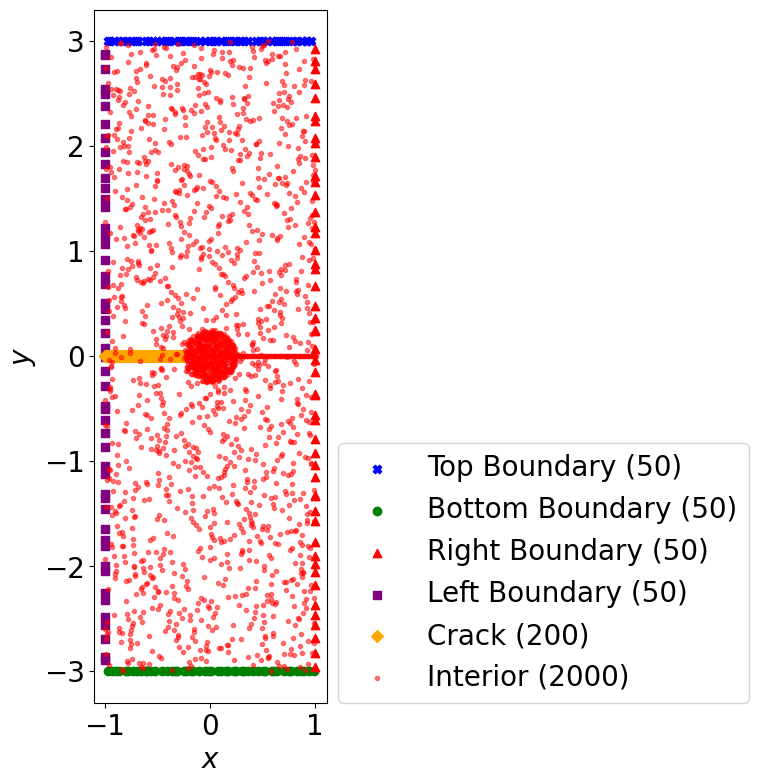

In [6]:
# Lower bounds
lb = torch.tensor([xmin, ymin], dtype=DTYPE)
# Upper bounds
ub = torch.tensor([xmax, ymax], dtype=DTYPE)

X_b_train, X_train_list, ux_b_train, uy_b_train, Sxx_b_train, Syy_b_train, \
        Syy_crack_train = getBoundary_points(xmin,xmax,ymin,ymax,DTYPE,N_bound,N_crack)
X_col_train = getCollocation_points_m(xmin,xmax,ymin,ymax,N_r,N_r_J,N_tip)

#绘制采样点
[x_up_train, x_lo_train, x_ri_train, x_le_train, crack_train] = X_train_list
fig = plt.figure(figsize=(3,9))

# 为每组边界点指定颜色、记号和标签
boundary_data = [
    (x_up_train, 'blue', 'X', 'Top Boundary'),
    (x_lo_train, 'green', 'o', 'Bottom Boundary'),
    (x_ri_train, 'red', '^', 'Right Boundary'),
    (x_le_train, 'purple', 's', 'Left Boundary'),
    (crack_train, 'orange', 'D', 'Crack')
]
plt.rcParams.update({'font.size': 20})
# 绘制边界点
for boundary_train, color, marker, label in boundary_data:
    plt.scatter(boundary_train[:,0], boundary_train[:,1], c=color, marker=marker, label=f"{label} ({len(boundary_train)})")
# 绘制配置点
plt.scatter(X_col_train[:,0], X_col_train[:,1], c='red', marker='.', alpha=0.5, label=f"Interior ({len(X_col_train)})")
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

# plt.title('Positions of collocation points and boundary data')
# 显示图例在右上角
plt.legend(loc=(1.05, 0))
# 保存图像
#plt.savefig('Xdata_Burgers.pdf', bbox_inches='tight', dpi=300)
plt.show()
plt.show()

### 网络设置

In [7]:
# 定义 Swish 激活函数
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

# 定义神经网络模型
class MNN(nn.Module):
    def __init__(self, layers, labels=1):
        super().__init__()
        # Initialise neural network as a list using nn.ModuleList
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        # 对每个层的权重进行了Xavier正态初始化，同时将偏置设置为零
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
        
        # 定义激活函数，这里我们使用ReLU和Swish作为示例
        self.activations = [
            nn.ReLU(),
            Swish(),
            nn.Tanh(),
            nn.Sigmoid(),
            nn.Softplus(), #平滑版本的 ReLU，公式为 f(x) = log(exp(x) + 1)
            nn.Softsign() #输出值在 -1 和 1 之间，公式为 f(x) = x / (1 + |x|)
        ]

    def forward(self, x, labels):
        if not torch.is_tensor(x):          
            x = torch.from_numpy(x)
        for i in range(len(self.linears)-1):  
            x = self.linears[i](x)
            x = self.activations[labels](x)
        x = self.linears[-1](x)
        output_Ux = x[:,0][:,None]
        output_Uy = x[:,1][:,None]
        output_Sxx = x[:,2][:,None]
        output_Syy = x[:,3][:,None]
        output_Sxy = x[:,4][:,None]
        return output_Ux, output_Uy, output_Sxx, output_Syy, output_Sxy
# Create the model
layers = [2] + num_hidden * [num_nodes] + [5]
modelMNN = MNN(layers)
#print(model) #打印模型结构

In [8]:
def split_tensors_by_condition(x, y, condition_func_x, condition_func_y):
    """
    根据条件函数将x和y张量分成两组。

    参数:
    x -- 第一个张量
    y -- 第二个张量
    condition_func -- 条件函数，接受y作为参数，返回一个布尔张量

    返回:
    x_true, y_true, x_false, y_false -- 关于满足和不满足条件的坐标
    labels -- 关于满足条件的标签
    """
    # 应用条件函数获取布尔索引
    if condition_func_x is not None:
        condition_x = condition_func_x(x)
    else:
        # 如果 condition_func_x 是 None，使用全为 True 的布尔向量
        condition_x = torch.ones_like(x).bool()
    if condition_func_y is not None:
        condition_y = condition_func_y(y)
    else:
        # 如果 condition_func_y 是 None，使用全为 True 的布尔向量
        condition_y = torch.ones_like(y).bool()
    if condition_x is None and condition_y is None:
        raise ValueError("至少需要提供一个条件函数")
    else:
        condition = condition_x & condition_y
        
    # 使用布尔索引筛选张量
    x_true = x[condition].unsqueeze(1) # 将 x_t 转换为形状 [m, 1]
    y_true = y[condition].unsqueeze(1)
    x_false = x[~condition].unsqueeze(1)
    y_false = y[~condition].unsqueeze(1)
    labels_t = ACT_function_1
    labels_f = ACT_function_2
    return x_true, y_true, x_false, y_false, labels_t, labels_f

def split_target_by_condition(x, y, train, condition_func_x, condition_func_y):
    """
    根据条件函数将目标train_point分成两组。

    参数:
    x -- 第一个张量
    y -- 第二个张量
    train -- 训练目标
    condition_func -- 条件函数，接受y作为参数，返回一个布尔张量

    返回:
    train_true, train_false -- 关于满足和不满足条件的训练目标
    """
    # 应用条件函数获取布尔索引
    if condition_func_x is not None:
        condition_x = condition_func_x(x)
    else:
        # 如果 condition_func_x 是 None，使用全为 True 的布尔向量
        condition_x = torch.ones_like(x).bool()
    if condition_func_y is not None:
        condition_y = condition_func_y(y)
    else:
        # 如果 condition_func_y 是 None，使用全为 True 的布尔向量
        condition_y = torch.ones_like(y).bool()
    if condition_x is None and condition_y is None:
        raise ValueError("至少需要提供一个条件函数")
    else:
        condition = condition_x & condition_y
        
    # 使用布尔索引筛选张量
    train_true = train[condition].unsqueeze(1) # 将 x_t 转换为形状 [m, 1]
    train_false = train[~condition].unsqueeze(1)
    return train_true, train_false


### 损失函数

#### PED损失

In [9]:
def fun_r_x(x, y, dsxxdx, dsxydy):
    return dsxxdx + dsxydy

def fun_r_y(x, y, dsxydx, dsyydy):
    return dsxydx + dsyydy

def fun_r_const_x(x, y, duxdx, duydy, Sxx):
    return (lmda + 2 * mu) * duxdx + lmda * duydy - Sxx

def fun_r_const_y(x, y, duxdx, duydy, Syy):
    return (lmda + 2 * mu) * duydy + lmda * duxdx - Syy

def fun_r_const_xy(x, y, duxdy, duydx, Sxy):
    return 2 * mu * 0.5 * (duxdy + duydx) - Sxy

#ux_b_train, uy_b_train, Sxx_b_train, Syy_b_train, Sxx_crack_train, Syy_crack_train, Sxy_crack_train
#的顺序需要依据x，y重配置的顺序改变，否则训练会出错
def fun_b_r_ux(ux_up, ux_lo, ux_ri, ux_le, ux_b_train):
    return torch.cat((ux_up, ux_lo, ux_ri, ux_le), dim=0) - ux_b_train

def fun_b_r_uy(uy_up, uy_lo,uy_ri, uy_le, uy_b_train):
    return torch.cat((uy_up, uy_lo,uy_ri, uy_le), dim=0) - uy_b_train

def fun_b_r_Sxx(Sxx_up, Sxx_lo, Sxx_ri, Sxx_le, Sxx_b_train):
    return torch.cat((Sxx_up, Sxx_lo, Sxx_ri, Sxx_le), dim=0) - Sxx_b_train

def fun_b_r_Syy(Syy_up, Syy_lo, Syy_ri, Syy_le, Syy_b_train):
    return torch.cat((Syy_up, Syy_lo, Syy_ri, Syy_le), dim=0) - Syy_b_train

def fun_crack_r_Sxx(Sxx_crack, Sxx_crack_train):
    return Sxx_crack - Sxx_crack_train

def fun_crack_r_Syy(Syy_crack, Syy_crack_train):
    return Syy_crack - Syy_crack_train

def fun_crack_r_Sxy(Sxy_crack, Sxy_crack_train):
    return Sxy_crack - Sxy_crack_train

In [10]:
def compute_tipregion_u_x(u_x, x, y):
    if not torch.is_tensor(x):
        x = torch.from_numpy(x)
    if not torch.is_tensor(y):
        y = torch.from_numpy(y)
    r= rr(x, y)
    th= theta(x, y)
    utemp = u_x/(2*mu)*torch.sqrt(r/(2*torch.pi))* torch.cos(0.5 * th) *(kappa-1+2*(torch.sin(0.5 * th))**2)
    return utemp
def compute_tipregion_u_y(u_y, x, y):
    if not torch.is_tensor(x):
        x = torch.from_numpy(x)
    if not torch.is_tensor(y):
        y = torch.from_numpy(y)
    r= rr(x, y)
    th= theta(x, y)
    utemp = u_y/(2*mu)*torch.sqrt(r/(2*torch.pi))* torch.sin(0.5 * th) *(kappa+1-2*(torch.cos(0.5 * th))**2)
    return utemp

def compute_tipregion_Sxx(Sxx, x, y):
    if not torch.is_tensor(x):
        x = torch.from_numpy(x)
    if not torch.is_tensor(y):
        y = torch.from_numpy(y)
    r= rr(x, y)
    th= theta(x, y)
    gtemp = Sxx / torch.sqrt(2 * torch.pi * r) * torch.cos(0.5 * th) * (1 - torch.sin(0.5 * th) * torch.sin(1.5 * th))
    return gtemp

def compute_tipregion_Syy(Syy, x, y):
    if not torch.is_tensor(x):
        x = torch.from_numpy(x)
    if not torch.is_tensor(y):
        y = torch.from_numpy(y)
    r= rr(x, y)
    th= theta(x, y)
    gtemp = Syy / torch.sqrt(2 * torch.pi * r) * torch.cos(0.5 * th) * (1 + torch.sin(0.5 * th) * torch.sin(1.5 * th))
    return gtemp

def compute_tipregion_Sxy(Sxy, x, y):
    if not torch.is_tensor(x):
        x = torch.from_numpy(x)
    if not torch.is_tensor(y):
        y = torch.from_numpy(y)
    r= rr(x, y)
    th= theta(x, y)
    gtemp = Sxy / torch.sqrt(2 * torch.pi * r) * torch.cos(0.5 * th) * torch.sin(0.5 * th) * torch.cos(1.5 * th)
    return gtemp

In [13]:

#内部点处的数值LOSS和PED_LOSS

# 定义一个函数来计算和拼接梯度
def compute_grads(var_t, var_f, x_t, y_t, x_f, y_f):
    grads_t = torch.autograd.grad(var_t, [x_t, y_t], torch.ones_like(var_t), create_graph=True)
    grads_f = torch.autograd.grad(var_f, [x_f, y_f], torch.ones_like(var_f), create_graph=True)
    grads_x_t, grads_y_t = grads_t[0], grads_t[1]
    grads_x_f, grads_y_f = grads_f[0], grads_f[1]
    return (torch.cat((grads_x_t, grads_x_f), dim=0), torch.cat((grads_y_t, grads_y_f), dim=0))

def get_r(model, X_col_train):
    # Split x and y to compute partial derivatives
    x = X_col_train[:, 0].clone().requires_grad_(True)[:,None]
    y = X_col_train[:, 1].clone().requires_grad_(True)[:,None]
    x_t, y_t, x_f, y_f, labels_t, labels_f = split_tensors_by_condition(x, y, None,lambda y:y < 0)
    #print(torch.hstack([x, y]).shape, torch.hstack([x_t, y_t]).shape)
    # Determine residual

    Ux_t, Uy_t, Sxx_t, Syy_t, Sxy_t = model(torch.hstack([x_t, y_t]), labels_t)
    Ux_f, Uy_f, Sxx_f, Syy_f, Sxy_f = model(torch.hstack([x_f, y_f]), labels_f)
    x = torch.cat((x_t, x_f), dim=0).clone().requires_grad_(True)[:,None]
    y = torch.cat((y_t, y_f), dim=0).clone().requires_grad_(True)[:,None]

    # Compute gradients of ux and uy
    Ux_t = compute_tipregion_u_x(Ux_t, x_t, y_t)
    Ux_f = compute_tipregion_u_x(Ux_f, x_f, y_f)

    Uy_t = compute_tipregion_u_y(Uy_t, x_t, y_t)
    Uy_f = compute_tipregion_u_y(Uy_f, x_f, y_f)

    duxdx, duxdy = compute_grads(Ux_t, Ux_f, x_t, y_t, x_f, y_f)

    duydx, duydy = compute_grads(Uy_t, Uy_f, x_t, y_t, x_f, y_f)
    
    # Compute gradients of sxx, syy, and sxy
    Sxx_t = compute_tipregion_Sxx(Sxx_t, x_t,y_t)
    Sxx_f = compute_tipregion_Sxx(Sxx_f, x_f,y_f)

    Syy_t = compute_tipregion_Syy(Syy_t, x_t,y_t)
    Syy_f = compute_tipregion_Syy(Syy_f, x_f,y_f)

    Sxy_t = compute_tipregion_Sxy(Sxy_t, x_t,y_t)
    Sxy_f = compute_tipregion_Sxy(Sxy_f, x_f,y_f)

    dsxxdx, _ = compute_grads(Sxx_t, Sxx_f, x_t, y_t, x_f, y_f)

    _, dsyydy = compute_grads(Syy_t, Syy_f, x_t, y_t, x_f, y_f)
    
    dsxydx, dsxydy = compute_grads(Sxy_t, Sxy_f, x_t, y_t, x_f, y_f)

    sxx = torch.cat((Sxx_t, Sxx_f), dim=0)
    syy = torch.cat((Syy_t, Syy_f), dim=0)
    sxy = torch.cat((Sxy_t, Sxy_f), dim=0)

    return fun_r_x(x, y, dsxxdx, dsxydy), fun_r_y(x, y, dsxydx, dsyydy), \
        fun_r_const_x(x, y, duxdx, duydy, sxx), fun_r_const_y(x, y, duxdx, duydy, syy), \
            fun_r_const_xy(x, y, duxdy, duydx, sxy)

#### 连接处的损失

In [14]:
#在连接处的内部点，采用不同激活函数的数值Loss
def get_ir(model, X_col_train):
    # Split x and y to compute partial derivatives
    x = X_col_train[:, 0].clone().requires_grad_(True)[:, None]
    y = X_col_train[:, 1].clone().requires_grad_(True)[:, None]
    
    # 筛选出x > 0且y == 0+-0.02的元素
    x_t, y_t, _, _, labels_t, labels_f = split_tensors_by_condition(x, y, lambda x: x > 0, lambda y: (y > -0.02) & (y < 0.02))
    
    # 检查x_t或y_t是否为空
    if x_t.numel() == 0 or y_t.numel() == 0:
        return 0.0
    
    # Determine residual
    Ux_0, Uy_0, Sxx_0, Syy_0, Sxy_0 = model(torch.hstack([x_t, y_t]), labels_t)
    Ux_1, Uy_1, Sxx_1, Syy_1, Sxy_1 = model(torch.hstack([x_t, y_t]), labels_f)

    Ux_0 = compute_tipregion_u_x(Ux_0, x_t, y_t)
    Ux_1 = compute_tipregion_u_x(Ux_1, x_t, y_t)

    Uy_0 = compute_tipregion_u_y(Uy_0, x_t, y_t)
    Uy_1 = compute_tipregion_u_y(Uy_1, x_t, y_t)

    Sxx_0 = compute_tipregion_Sxx(Sxx_0, x_t, y_t)
    Sxx_1 = compute_tipregion_Sxx(Sxx_1, x_t, y_t)

    Syy_0 = compute_tipregion_Syy(Syy_0, x_t, y_t)
    Syy_1 = compute_tipregion_Syy(Syy_1, x_t, y_t)

    Sxy_0 = compute_tipregion_Sxy(Sxy_0, x_t, y_t)
    Sxy_1 = compute_tipregion_Sxy(Sxy_1, x_t, y_t)

    ux = Ux_0 - Ux_1
    uy = Uy_0 - Uy_1

    # 硬连续条件
    grads_Ux_0 = torch.autograd.grad(Ux_0, [x_t, y_t], torch.ones_like(Ux_0), create_graph=True)
    grads_Ux_1 = torch.autograd.grad(Ux_1, [x_t, y_t], torch.ones_like(Ux_1), create_graph=True)
    Uxdx_0, Uxdy_0 = grads_Ux_0[0], grads_Ux_0[1]
    Uxdx_1, Uxdy_1 = grads_Ux_1[0], grads_Ux_1[1]
    Uxdx = Uxdx_0 - Uxdx_1
    Uxdy = Uxdy_0 - Uxdy_1

    grads_Uy_0 = torch.autograd.grad(Uy_0, [x_t, y_t], torch.ones_like(Uy_0), create_graph=True)
    grads_Uy_1 = torch.autograd.grad(Uy_1, [x_t, y_t], torch.ones_like(Uy_1), create_graph=True)
    Uydx_0, Uydy_0 = grads_Uy_0[0], grads_Uy_0[1]
    Uydx_1, Uydy_1 = grads_Uy_1[0], grads_Uy_1[1]
    Uydx = Uydx_0 - Uydx_1
    Uydy = Uydy_0 - Uydy_1

    Sxx = Sxx_0 - Sxx_1
    Syy = Syy_0 - Syy_1
    Sxy = Sxy_0 - Sxy_1
    return torch.mean(torch.abs(ux)**2) + torch.mean(torch.abs(uy)**2) \
        + torch.mean(torch.abs(Uxdx)**2) + torch.mean(torch.abs(Uxdy)**2) \
        + torch.mean(torch.abs(Uydx)**2) + torch.mean(torch.abs(Uydy)**2) \
        + torch.mean(torch.abs(Sxx)**2) + torch.mean(torch.abs(Syy)**2) + torch.mean(torch.abs(Sxy)**2)

#### 边界处的损失

In [ ]:

#边界处的数值LOSS和PED_LOSS

def get_b_r_uS(model, X_train_list, ux_b_train, uy_b_train, \
               Sxx_b_train, Syy_b_train,\
                 Syy_crack_train):
    
    x_up_train, x_lo_train, x_ri_train, x_le_train, crack_train = X_train_list[0], \
                    X_train_list[1], X_train_list[2], X_train_list[3], X_train_list[4]
    # Split x and y to compute partial derivatives
    x_up, y_up = x_up_train[:, 0][:,None], x_up_train[:, 1][:,None]
    x_lo, y_lo = x_lo_train[:, 0][:,None], x_lo_train[:, 1][:,None]
    x_ri, y_ri = x_ri_train[:, 0][:,None], x_ri_train[:, 1][:,None]
    x_le, y_le = x_le_train[:, 0][:,None], x_le_train[:, 1][:,None]
    ##crack boundary
    x_crack, y_crack = crack_train[:, 0][:,None], crack_train[:, 1][:,None]

    #上边界，下边界 和 裂缝 自然不用分类
    x_ri_t, y_ri_t, x_ri_f, y_ri_f, labels_ri_t, labels_ri_f = split_tensors_by_condition(x_ri, y_ri, None, lambda y:y < 0)
    x_le_t, y_le_t, x_le_f, y_le_f, labels_le_t, labels_le_f = split_tensors_by_condition(x_le, y_le, None, lambda y:y < 0)

    # Determine residual
    Ux_up, Uy_up, Sxx_up, Syy_up, Sxy_up  = model(torch.hstack((x_up, y_up)), labels_ri_f)
    Ux_lo, Uy_lo, Sxx_lo, Syy_lo, Sxy_lo  = model(torch.hstack((x_lo, y_lo)), labels_ri_t)

    _, _, Sxx_crack, Syy_crack, Sxy_crack  = model(torch.hstack((x_crack, y_crack)), labels_ri_f)
    
    Ux_up = compute_tipregion_u_x(Ux_up, x_up, y_up)
    Uy_up = compute_tipregion_u_y(Uy_up, x_up, y_up)
    Sxx_up = compute_tipregion_Sxx(Sxx_up, x_up, y_up)
    Syy_up = compute_tipregion_Syy(Syy_up, x_up, y_up)
    Sxy_up = compute_tipregion_Sxy(Sxy_up, x_up, y_up)
    
    Ux_lo = compute_tipregion_u_x(Ux_lo, x_lo, y_lo)
    Uy_lo = compute_tipregion_u_y(Uy_lo, x_lo, y_lo)
    Sxx_lo = compute_tipregion_Sxx(Sxx_lo, x_lo, y_lo)
    Syy_lo = compute_tipregion_Syy(Syy_lo, x_lo, y_lo)
    Sxy_lo = compute_tipregion_Sxy(Sxy_lo, x_lo, y_lo)

    Sxx_crack = compute_tipregion_Sxx(Sxx_crack, x_crack, y_crack)
    Syy_crack = compute_tipregion_Syy(Syy_crack, x_crack, y_crack)
    Sxy_crack = compute_tipregion_Sxy(Sxy_crack, x_crack, y_crack)


    Ux_ri_t, Uy_ri_t, Sxx_ri_t, Syy_ri_t, Sxy_ri_t  = model(torch.hstack((x_ri_t, y_ri_t)), labels_ri_t)
    Ux_ri_f, Uy_ri_f, Sxx_ri_f, Syy_ri_f, Sxy_ri_f  = model(torch.hstack((x_ri_f, y_ri_f)), labels_ri_f)
    Ux_ri_t = compute_tipregion_u_x(Ux_ri_t, x_ri_t, y_ri_t)
    Ux_ri_f = compute_tipregion_u_x(Ux_ri_f, x_ri_f, y_ri_f)

    Uy_ri_t = compute_tipregion_u_y(Uy_ri_t, x_ri_t, y_ri_t)
    Uy_ri_f = compute_tipregion_u_y(Uy_ri_f, x_ri_f, y_ri_f)

    Sxx_ri_t = compute_tipregion_Sxx(Sxx_ri_t, x_ri_t, y_ri_t)
    Sxx_ri_f = compute_tipregion_Sxx(Sxx_ri_f, x_ri_f, y_ri_f)
    Syy_ri_t = compute_tipregion_Syy(Syy_ri_t, x_ri_t, y_ri_t)
    Syy_ri_f = compute_tipregion_Syy(Syy_ri_f, x_ri_f, y_ri_f)
    Sxy_ri_t = compute_tipregion_Sxy(Sxy_ri_t, x_ri_t, y_ri_t)
    Sxy_ri_f = compute_tipregion_Sxy(Sxy_ri_f, x_ri_f, y_ri_f)


    Ux_ri = torch.cat((Ux_ri_t, Ux_ri_f), dim=0).clone().requires_grad_(True)
    Uy_ri = torch.cat((Uy_ri_t, Uy_ri_f), dim=0).clone().requires_grad_(True)
    Sxx_ri = torch.cat((Sxx_ri_t, Sxx_ri_f), dim=0).clone().requires_grad_(True)
    Syy_ri = torch.cat((Syy_ri_t, Syy_ri_f), dim=0).clone().requires_grad_(True)
    Sxy_ri = torch.cat((Sxy_ri_t, Sxy_ri_f), dim=0).clone().requires_grad_(True)



    Ux_le_t, Uy_le_t, Sxx_le_t, Syy_le_t, Sxy_le_t  = model(torch.hstack((x_le_t, y_le_t)), labels_le_t)
    Ux_le_f, Uy_le_f, Sxx_le_f, Syy_le_f, Sxy_le_f  = model(torch.hstack((x_le_f, y_le_f)), labels_le_f)
    Ux_le_t = compute_tipregion_u_x(Ux_le_t, x_le_t, y_le_t)
    Ux_le_f = compute_tipregion_u_x(Ux_le_f, x_le_f, y_le_f)

    Uy_le_t = compute_tipregion_u_y(Uy_le_t, x_le_t, y_le_t)
    Uy_le_f = compute_tipregion_u_y(Uy_le_f, x_le_f, y_le_f)

    Sxx_le_t = compute_tipregion_Sxx(Sxx_le_t, x_le_t, y_le_t)
    Sxx_le_f = compute_tipregion_Sxx(Sxx_le_f, x_le_f, y_le_f)
    Syy_le_t = compute_tipregion_Syy(Syy_le_t, x_le_t, y_le_t)
    Syy_le_f = compute_tipregion_Syy(Syy_le_f, x_le_f, y_le_f)
    Sxy_le_t = compute_tipregion_Sxy(Sxy_le_t, x_le_t, y_le_t)
    Sxy_le_f = compute_tipregion_Sxy(Sxy_le_f, x_le_f, y_le_f)
    
    Ux_le = torch.cat((Ux_le_t, Ux_le_f), dim=0).clone().requires_grad_(True)
    Uy_le = torch.cat((Uy_le_t, Uy_le_f), dim=0).clone().requires_grad_(True)
    Sxx_le = torch.cat((Sxx_le_t, Sxx_le_f), dim=0).clone().requires_grad_(True)
    Syy_le = torch.cat((Syy_le_t, Syy_le_f), dim=0).clone().requires_grad_(True)
    Sxy_le = torch.cat((Sxy_le_t, Sxy_le_f), dim=0).clone().requires_grad_(True)

    #修正ux_b_train
    ux_up_train_extracted = ux_b_train[:N_bound].clone()
    ux_lo_train_extracted = ux_b_train[N_bound:2*N_bound].clone()
    ux_ri_train_extracted = ux_b_train[2*N_bound:3*N_bound].clone()
    ux_le_train_extracted = ux_b_train[3*N_bound:4*N_bound].clone()
    ux_ri_train_extracted_t, ux_ri_train_extracted_f = split_target_by_condition(x_ri, y_ri, ux_ri_train_extracted, None, lambda y:y < 0)
    ux_ri_train_extracted = torch.cat((ux_ri_train_extracted_t, ux_ri_train_extracted_f), dim=0)
    ux_le_train_extracted_t, ux_le_train_extracted_f = split_target_by_condition(x_le, y_le, ux_le_train_extracted, None, lambda y:y < 0)
    ux_le_train_extracted = torch.cat((ux_le_train_extracted_t, ux_le_train_extracted_f), dim=0)
    ux_b_train = torch.cat((ux_up_train_extracted, ux_lo_train_extracted, ux_ri_train_extracted, ux_le_train_extracted), dim=0)

    #修正uy_b_train
    uy_up_train_extracted = uy_b_train[:N_bound].clone()
    uy_lo_train_extracted = uy_b_train[N_bound:2*N_bound].clone()
    uy_ri_train_extracted = uy_b_train[2*N_bound:3*N_bound].clone()
    uy_le_train_extracted = uy_b_train[3*N_bound:4*N_bound].clone()
    uy_ri_train_extracted_t, uy_ri_train_extracted_f = split_target_by_condition(x_ri, y_ri, uy_ri_train_extracted, None, lambda y:y < 0)
    uy_ri_train_extracted = torch.cat((uy_ri_train_extracted_t, uy_ri_train_extracted_f), dim=0)
    uy_le_train_extracted_t, uy_le_train_extracted_f = split_target_by_condition(x_le, y_le, uy_le_train_extracted, None, lambda y:y < 0)
    uy_le_train_extracted = torch.cat((uy_le_train_extracted_t, uy_le_train_extracted_f), dim=0)
    uy_b_train = torch.cat((uy_up_train_extracted, uy_lo_train_extracted, uy_ri_train_extracted, uy_le_train_extracted), dim=0)

    #修正Sxx_b_train
    Sxx_up_train_extracted = Sxx_b_train[:N_bound].clone()
    Sxx_lo_train_extracted = Sxx_b_train[N_bound:2*N_bound].clone()
    Sxx_ri_train_extracted = Sxx_b_train[2*N_bound:3*N_bound].clone()
    Sxx_le_train_extracted = Sxx_b_train[3*N_bound:4*N_bound].clone()
    Sxx_ri_train_extracted_t, Sxx_ri_train_extracted_f = split_target_by_condition(x_ri, y_ri, Sxx_ri_train_extracted, None, lambda y:y < 0)
    Sxx_ri_train_extracted = torch.cat((Sxx_ri_train_extracted_t, Sxx_ri_train_extracted_f), dim=0)
    Sxx_le_train_extracted_t, Sxx_le_train_extracted_f = split_target_by_condition(x_le, y_le, Sxx_le_train_extracted, None, lambda y:y < 0)
    Sxx_le_train_extracted = torch.cat((Sxx_up_train_extracted, Sxx_lo_train_extracted, Sxx_le_train_extracted_t, Sxx_le_train_extracted_f), dim=0)
    Sxx_b_train = torch.cat((Sxx_ri_train_extracted, Sxx_le_train_extracted), dim=0)

    #对应的，不用修正 Sxx_crack_train, Syy_crack_train, Sxy_crack_train

    ux_up, uy_up = Ux_up, Uy_up
    ux_lo, uy_lo = Ux_lo, Uy_lo
    ux_ri, uy_ri = Ux_ri, Uy_ri
    ux_le, uy_le = Ux_le, Uy_le

    return fun_b_r_ux(ux_up, ux_lo, ux_ri, ux_le, ux_b_train), fun_b_r_uy(uy_up, uy_lo, uy_ri, uy_le, uy_b_train),\
        fun_b_r_Sxx(Sxx_up,Sxx_lo, Sxx_ri, Sxx_le, Sxx_b_train), fun_b_r_Syy(Syy_up,Syy_lo, Syy_ri, Syy_le, Syy_b_train),\
            fun_crack_r_Syy(Syy_crack, Syy_crack_train)

### 损失函数汇总

In [ ]:
def compute_loss_addCrack(model, X_col_train, X_train_list, ux_b_train, uy_b_train, Sxx_b_train, Syy_b_train, Syy_crack_train):

    # Compute phi^r use absolute error
    rx, ry, rx_const, ry_const, rxy_const = get_r(model, X_col_train)
    phi_r = torch.mean(torch.abs(rx)**2) + torch.mean(torch.abs(ry)**2)
    phi_r_const = torch.mean(torch.abs(rx_const)**2) + torch.mean(torch.abs(ry_const)**2) + torch.mean(torch.abs(rxy_const)**2)
    phi_ir = get_ir(model, X_col_train)

    # Compute phi^b
    r_ux, r_uy, r_Sxx, r_Syy, rc_Syy  = get_b_r_uS(model, X_train_list, ux_b_train, uy_b_train, Sxx_b_train, Syy_b_train, Syy_crack_train)
    phi_r_u = torch.mean(torch.abs(r_ux)**2) + torch.mean(torch.abs(r_uy)**2)
    phi_r_S = torch.mean(torch.abs(r_Sxx)**2) + torch.mean(torch.abs(r_Syy)**2)\
    + torch.mean(torch.abs(rc_Syy)**2)

    loss = phi_r**(1/3) + phi_r_const**(1/3) + phi_r_u**(1/3) + phi_r_S**(1/3)
    #loss = phi_r + phi_r_const + phi_r_u + phi_r_S + phi_ir
    return loss, phi_r, phi_r_const, phi_r_u, phi_r_S, phi_ir

def get_grad_addCrack(model, X_col_train, X_train_list, ux_b_train, uy_b_train, Sxx_b_train, Syy_b_train, Syy_crack_train):
    # Set requires_grad=True for trainable parameters
    for param in model.parameters():
        param.requires_grad = True

    # Forward pass and compute loss
    loss, phi_r, phi_r_const, phi_r_u, phi_r_S, phi_ir= compute_loss_addCrack(model, X_col_train, X_train_list, ux_b_train, uy_b_train, Sxx_b_train, Syy_b_train, Syy_crack_train)

    # Backward pass
    loss.backward()

    # Get gradients
    g = [param.grad.clone() for param in model.parameters()]

    return loss, g, phi_r, phi_r_const, phi_r_u, phi_r_S, phi_ir

### 训练模型

In [17]:
# Choose the optimizer  优化器选择，Adam利用梯度的一阶矩估计和二阶矩估计动态调整每个参数的学习率。
# 它的优点主要在于经过偏置校正后，每一次迭代学习率都有个确定范围，使得参数比较平稳。
lr = 1e-3 #学习率，更新梯度的时候使用

optimizer = optim.Adam(modelMNN.parameters(), lr=lr)
scheduler = MultiStepLR(optimizer=optimizer, milestones=[num_epochs/20, num_epochs/10], gamma=0.1)

# Number of training epochs
num_epochs
hist = []
hist_loss = []
hist_phi_r = []
hist_phi_r_const = []
hist_phi_r_u = []
hist_phi_r_S = []
hist_phi_ir = []
hist_phi_crack = []


# Define a training step
def train_step():
    #model.train()  # Set the model to training mode
    optimizer.zero_grad()  # Zero the gradients

    # Compute current loss
    loss, grad_theta, phi_r, phi_r_const, phi_r_u, phi_r_S, phi_ir= get_grad_addCrack(modelMNN, X_col_train, X_train_list, ux_b_train, uy_b_train, Sxx_b_train, Syy_b_train, Syy_crack_train)
        # Perform gradient descent step
    for i, param in enumerate(modelMNN.parameters()):
        param.grad = grad_theta[i]

    optimizer.step()

    return loss.item(), phi_r.item(), phi_r_const.item(), phi_r_u.item(), phi_r_S.item(), phi_ir.item()

# Start timer
t0 = time()

for i in tqdm(range(num_epochs+1)):
    loss, phi_r, phi_r_const, phi_r_u, phi_r_S, phi_ir = train_step()

    #将状态加载到优化器
    #optimizer.load_state_dict(optimizer_state)

    if i == 0:
        loss0 = loss
    hist.append(loss / loss0)
    hist_loss.append(loss)

    # Append the values to their respective lists
    hist_phi_r.append(phi_r)
    hist_phi_r_const.append(phi_r_const)
    hist_phi_r_u.append(phi_r_u)
    hist_phi_r_S.append(phi_r_S)
    hist_phi_ir.append(phi_ir)

    if hist[-1] <= 1e-12:
        print('Loss threshold reached. Stopping training.')
        break

    # Output current loss after 50 iterates
    if i % 1000 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i, loss))

# Print computation time
print('\nComputation time: {} seconds'.format(time() - t0))

  0%|          | 3/10001 [00:00<14:49, 11.24it/s]

It 00000: loss = 6.80033570e+00


 10%|█         | 1003/10001 [01:30<13:44, 10.91it/s]

It 01000: loss = 5.91949566e+00


 20%|██        | 2003/10001 [03:01<12:14, 10.89it/s]

It 02000: loss = 5.89981858e+00


 30%|███       | 3003/10001 [04:33<10:48, 10.79it/s]

It 03000: loss = 5.89358502e+00


 40%|████      | 4003/10001 [06:05<09:15, 10.80it/s]

It 04000: loss = 5.87456112e+00


 50%|█████     | 5003/10001 [07:38<07:33, 11.02it/s]

It 05000: loss = 5.83435651e+00


 60%|██████    | 6003/10001 [09:11<06:07, 10.88it/s]

It 06000: loss = 5.81146315e+00


 70%|███████   | 7003/10001 [10:44<04:37, 10.80it/s]

It 07000: loss = 5.81147835e+00


 80%|████████  | 8003/10001 [12:17<03:03, 10.91it/s]

It 08000: loss = 5.51724620e+00


 90%|█████████ | 9003/10001 [13:51<01:33, 10.68it/s]

It 09000: loss = 1.60121996e+00


100%|██████████| 10001/10001 [15:24<00:00, 10.82it/s]

It 10000: loss = 1.30133325e+00

Computation time: 924.2024028301239 seconds


In [18]:
# 选择不同的优化方法LBFGS
opt_LBFGS = torch.optim.LBFGS(modelMNN.parameters(), lr=lr, max_iter=20)
# 不同方法的loss
loss_LBFGS = []

# Define a training step
def train_LBFGS_step():
    opt_LBFGS.zero_grad()

    # Define the closure function
    def closure():
        opt_LBFGS.zero_grad()
        loss, grad_theta, phi_r, phi_r_const, phi_r_u, phi_r_S, phi_ir = get_grad_addCrack(
            modelMNN, X_col_train, X_train_list, ux_b_train, uy_b_train, Sxx_b_train, Syy_b_train, Syy_crack_train
        )
        for i, param in enumerate(modelMNN.parameters()):
            param.grad = grad_theta[i]
        return loss

    # Perform the optimization step
    loss = opt_LBFGS.step(closure)

    # Extract the loss and other values from the closure
    loss, grad_theta, phi_r, phi_r_const, phi_r_u, phi_r_S, phi_ir = get_grad_addCrack(
        modelMNN, X_col_train, X_train_list, ux_b_train, uy_b_train, Sxx_b_train, Syy_b_train, Syy_crack_train
    )

    return loss.item(), phi_r.item(), phi_r_const.item(), phi_r_u.item(), phi_r_S.item(), phi_ir.item()

# Start timer
t0 = time()

for i in tqdm(range(N_l+1)):
    loss, phi_r, phi_r_const, phi_r_u, phi_r_S, phi_ir = train_LBFGS_step()

    #将状态加载到优化器
    #optimizer.load_state_dict(optimizer_state)
    if i == 0:
        loss0 = loss
    loss_LBFGS.append(loss / loss0)

    if loss_LBFGS[-1] <= 1e-10:
        print('Loss threshold reached. Stopping training.')
        break

    # Output current loss after 50 iterates
    if i % 1000 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i, loss))

# Print computation time
print('\nComputation time: {} seconds'.format(time() - t0))

  0%|          | 1/1001 [00:02<33:22,  2.00s/it]

It 00000: loss = 1.19622055e+00


100%|██████████| 1001/1001 [18:11<00:00,  1.09s/it]

It 01000: loss = 8.12030213e-01

Computation time: 1091.0213322639465 seconds


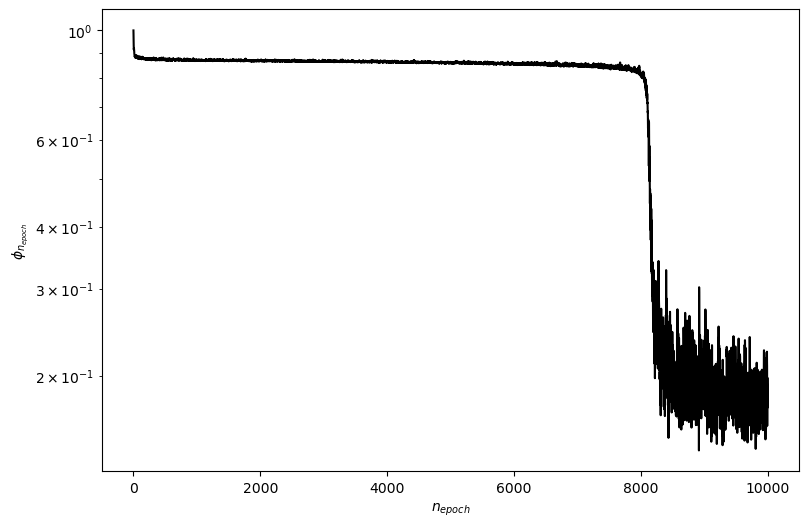

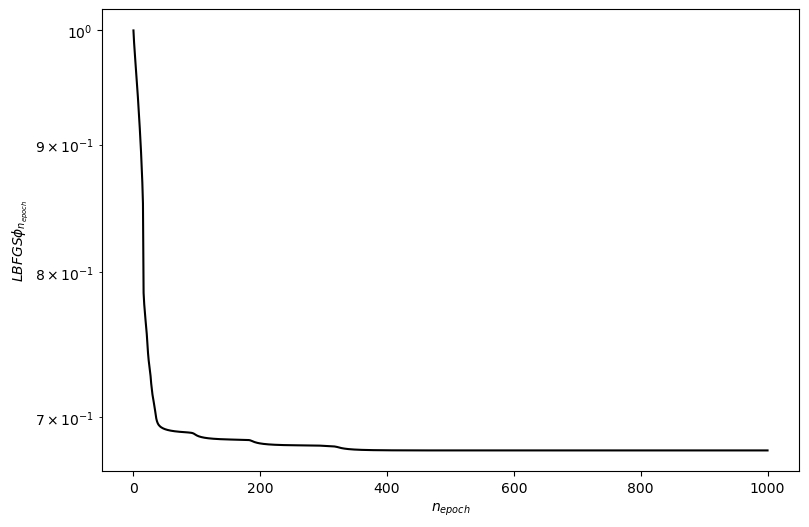

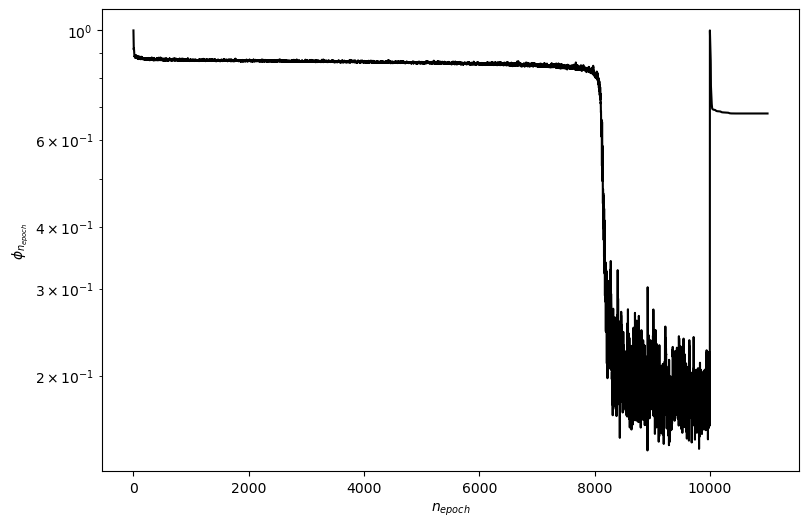

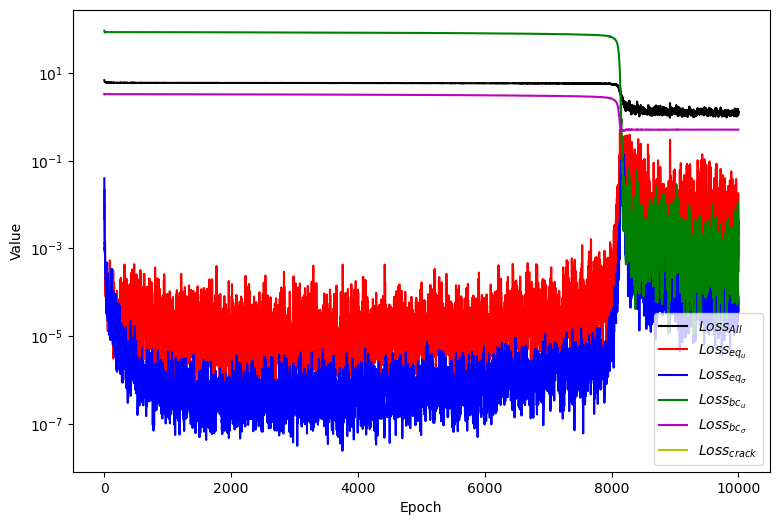

In [19]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(hist)), hist,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel(r'$\phi_{n_{epoch}}$')
plt.show()

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(loss_LBFGS)), loss_LBFGS,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel(r'$LBFGS\phi_{n_{epoch}}$')
plt.show()


hist_Adma_LB = np.concatenate((hist, loss_LBFGS))
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(hist_Adma_LB)), hist_Adma_LB,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel(r'$\phi_{n_{epoch}}$')
plt.show()

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
# 绘制损失值的半对数图
ax.semilogy(range(len(hist)), hist_loss, 'k-', label='$Loss_{All}$')
# 绘制 phi_r, phi_r_const, phi_r_u, phi_r_S, phi_ir 的半对数图
ax.semilogy(range(len(hist_phi_r)), hist_phi_r, 'r-', label='$Loss_{eq_u}$')
ax.semilogy(range(len(hist_phi_r_const)), hist_phi_r_const, 'b-', label=r'$Loss_{eq_\sigma}$')
ax.semilogy(range(len(hist_phi_r_u)), hist_phi_r_u, 'g-', label='$Loss_{bc_u}$')
ax.semilogy(range(len(hist_phi_r_S)), hist_phi_r_S, 'm-', label=r'$Loss_{bc_\sigma}$')
#ax.semilogy(range(len(hist_phi_ir)), hist_phi_ir, 'c-', label='$Loss_{jun}$')
ax.semilogy(range(len(hist_phi_crack)), hist_phi_crack, 'y-', label='$Loss_{crack}$')
ax.set_xlabel('Epoch')
ax.set_ylabel('Value')
ax.legend()
plt.show()


### 保存整个模型


In [33]:
torch.save(modelMNN, 'model_kf_g.pth')

import pickle

data = {
    'hist': hist,
    'hist_loss': hist_loss,
    'hist_phi_r': hist_phi_r,
    'hist_phi_r_const': hist_phi_r_const,
    'hist_phi_r_u': hist_phi_r_u,
    'hist_phi_r': hist_phi_r,
    'hist_phi_r_S': hist_phi_r_S,
    'hist_phi_ir': hist_phi_ir,
    'hist_phi_crack': hist_phi_crack
}

with open('training_hist_kf_g.pkl', 'wb') as f:
    pickle.dump(data, f)

### 结果及分析

In [17]:
import pickle
modelMNN = torch.load('model_kf_g.pth', weights_only=False)

with open('training_hist_kf_g.pkl', 'rb') as f:
    loaded_data = pickle.load(f)
hist = loaded_data['hist']
hist_loss = loaded_data['hist_loss']
hist_phi_r = loaded_data['hist_phi_r']
hist_phi_r_const = loaded_data['hist_phi_r_const']
hist_phi_r_u = loaded_data['hist_phi_r_u']
hist_phi_r_S = loaded_data['hist_phi_r_S']
hist_phi_ir = loaded_data['hist_phi_ir']
hist_phi_crack = loaded_data['hist_phi_crack']

In [18]:
# Set up meshgrid
N = 500
xspace = np.linspace(lb[0], ub[0], N + 1)
yspace = np.linspace(lb[1], ub[1], N + 1)
X, Y = np.meshgrid(xspace, yspace)

# 查找 (0, 0) 的位置
#idx_x = np.where(np.isclose(xspace, 0.0))[0]
#idx_y = np.where(np.isclose(yspace, 0.0))[0]

# 如果 (0, 0) 在网格中
#if len(idx_x) > 0 and len(idx_y) > 0:
    # 替换 (0, 0) 为 (1e-5, 1e-5)，可任意的小，避免出现裂尖单点奇异导致的数值inf溢出
#    X[idx_y[0], idx_x[0]] = 1e-5
#    Y[idx_y[0], idx_x[0]] = 1e-5


Xgrid = np.vstack([X.flatten(),Y.flatten()]).T
Xgrid_tensor = torch.tensor(Xgrid, dtype=DTYPE)
x_t, y_t, x_f, y_f, labels_t, labels_f = split_tensors_by_condition(Xgrid_tensor[:, 0], Xgrid_tensor[:, 1], None,lambda y:y < 0)

# Determine predictions of u(t, x)
Ux_pred_t, Uy_pred_t, Sxx_pred_t, Syy_pred_t, Sxy_pred_t = modelMNN(torch.hstack([x_t, y_t]), labels_t)
Ux_pred_f, Uy_pred_f, Sxx_pred_f, Syy_pred_f, Sxy_pred_f = modelMNN(torch.hstack([x_f, y_f]), labels_f)

Ux_pred_t = compute_tipregion_u_x(Ux_pred_t, x_t, y_t)
Ux_pred_f = compute_tipregion_u_x(Ux_pred_f, x_f, y_f)

Uy_pred_t = compute_tipregion_u_y(Uy_pred_t, x_t, y_t)
Uy_pred_f = compute_tipregion_u_y(Uy_pred_f, x_f, y_f)

Sxx_pred_t = compute_tipregion_Sxx(Sxx_pred_t, x_t, y_t)
Sxx_pred_f = compute_tipregion_Sxx(Sxx_pred_f, x_f, y_f)

Syy_pred_t = compute_tipregion_Syy(Syy_pred_t, x_t, y_t)
Syy_pred_f = compute_tipregion_Syy(Syy_pred_f, x_f, y_f)

Sxy_pred_t = compute_tipregion_Sxy(Sxy_pred_t, x_t, y_t)
Sxy_pred_f = compute_tipregion_Sxy(Sxy_pred_f, x_f, y_f)

ux_pred = torch.cat((Ux_pred_t, Ux_pred_f), dim=0)
uy_pred = torch.cat((Uy_pred_t, Uy_pred_f), dim=0)

# Reshape upred
Ux = ux_pred.detach().numpy().reshape(N+1,N+1)
Uy = uy_pred.detach().numpy().reshape(N+1,N+1)
Uhat = np.sqrt(Ux*Ux+Uy*Uy)


In [19]:
# calculate exact solutions
ux_ext = u_x_ext(X.flatten(),Y.flatten())
uy_ext = u_y_ext(X.flatten(),Y.flatten())

# Reshape upred
Ux_ext = ux_ext.detach().numpy().reshape(N+1,N+1)
Uy_ext = uy_ext.detach().numpy().reshape(N+1,N+1)
Uhat_ext = np.sqrt(Ux_ext*Ux_ext+Uy_ext*Uy_ext)

# Determine predictions of u(t, x)
sxx_pred = torch.cat((Sxx_pred_t, Sxx_pred_f), dim=0)
syy_pred = torch.cat((Syy_pred_t, Syy_pred_f), dim=0)
sxy_pred = torch.cat((Sxy_pred_t, Sxy_pred_f), dim=0)

# Reshape upred
Sxx = sxx_pred.detach().numpy().reshape(N+1,N+1)
Syy = syy_pred.detach().numpy().reshape(N+1,N+1)
Sxy = sxy_pred.detach().numpy().reshape(N+1,N+1)

sxx_ext = Sigmaxx_ext(X.flatten(),Y.flatten())
syy_ext = Sigmayy_ext(X.flatten(),Y.flatten())
sxy_ext = Sigmaxy_ext(X.flatten(),Y.flatten())

Sxx_ext = sxx_ext.detach().numpy().reshape(N+1,N+1)
Syy_ext = syy_ext.detach().numpy().reshape(N+1,N+1)
Sxy_ext = sxy_ext.detach().numpy().reshape(N+1,N+1)


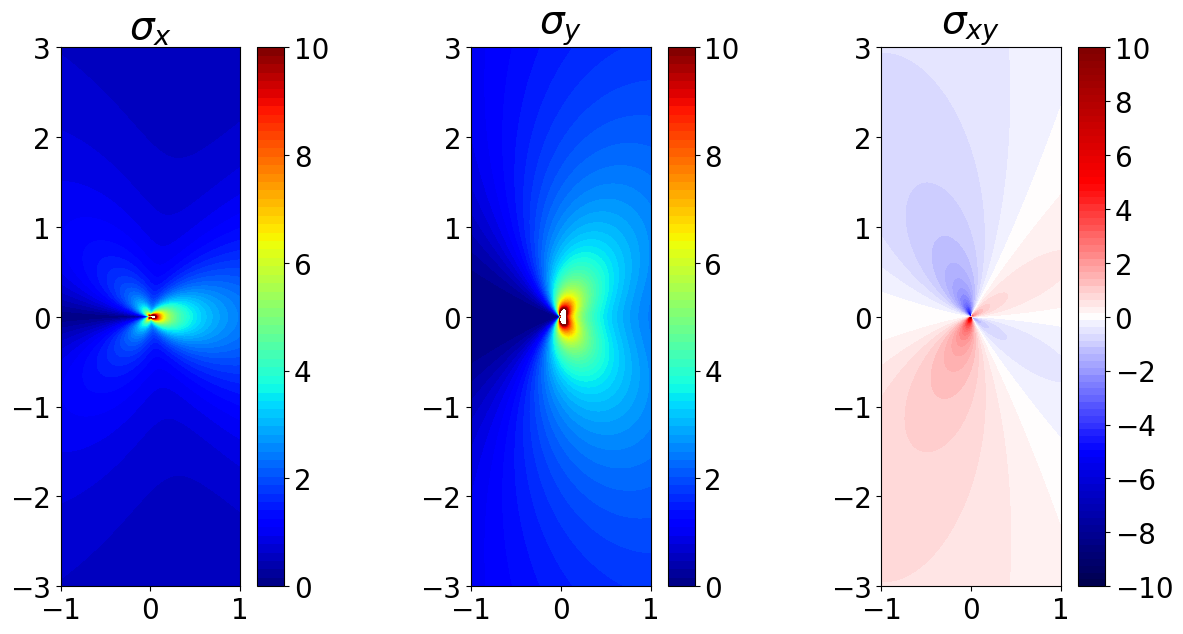

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
from matplotlib.ticker import ScalarFormatter

# 假设 X, Y, Sxx, Syy, Sxy 已定义
S_total = [Sxx, Syy, Sxy]
S_total_name = [
    r'$\sigma_{x}$',
    r'$\sigma_{y}$',
    r'$\sigma_{xy}$'
]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 7))

colorbar_ticks = [
    [0, 2, 4, 6, 8, 10],
    [0, 2, 4, 6, 8, 10],
    [-10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10]
]
colorbar_ticks_max = [10, 10, 10]
colorbar_ticks_min = [0, 0, -10]
colormaps = ['jet', 'jet', 'seismic']
level_counts = [65, 65, 80]

for i, ax in enumerate(axes.flat):
    # 手动生成 levels，确保覆盖 [vmin, vmax]
    levels = np.linspace(colorbar_ticks_min[i], colorbar_ticks_max[i], level_counts[i])
    
    im = ax.contourf(X, Y, S_total[i], levels=levels, cmap=colormaps[i],
                     vmin=colorbar_ticks_min[i], vmax=colorbar_ticks_max[i])
    
    ax.set_title(S_total_name[i], fontsize=28)
    cbar = fig.colorbar(im, ax=ax)
    cbar.locator = FixedLocator(colorbar_ticks[i])
    cbar.update_ticks()
    cbar.ax.yaxis.get_offset_text().set_visible(False)
    ax.set_aspect('equal')

plt.show()

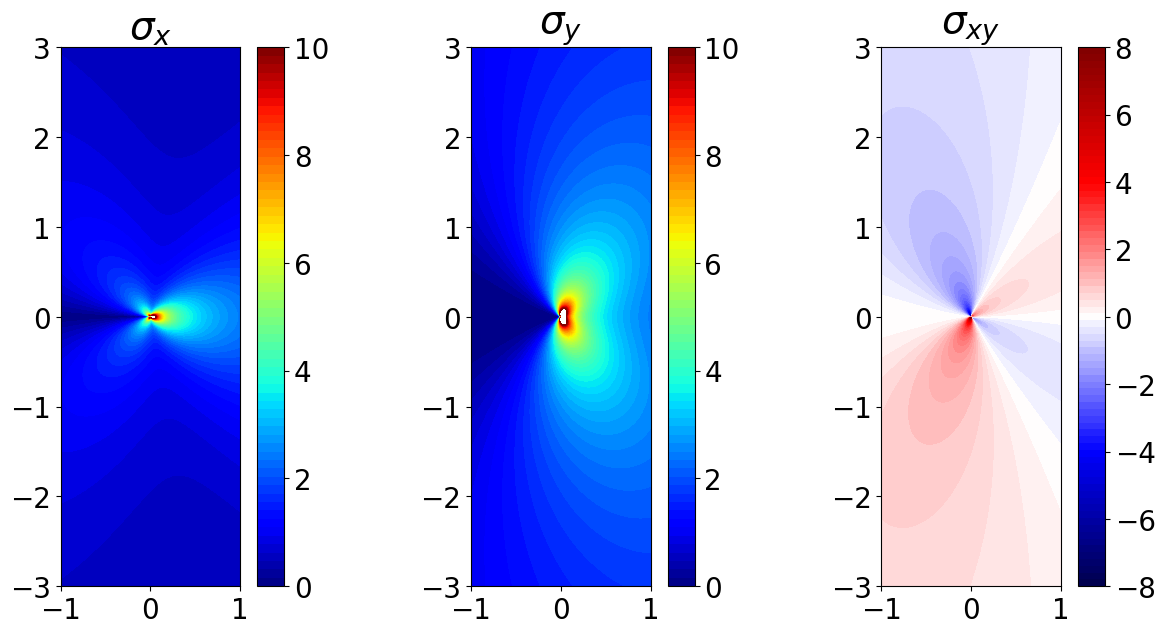

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
from matplotlib.ticker import ScalarFormatter

# 假设 X, Y, Sxx, Syy, Sxy 已定义
S_total = [Sxx_ext, Syy_ext, Sxy_ext]
S_total_name = [
    r'$\sigma_{x}$',
    r'$\sigma_{y}$',
    r'$\sigma_{xy}$'
]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 7))

colorbar_ticks = [
    [0, 2, 4, 6, 8, 10],
    [0, 2, 4, 6, 8, 10],
    [-8, -6, -4, -2, 0, 2, 4, 6, 8]
]
colorbar_ticks_max = [10, 10, 8]
colorbar_ticks_min = [0, 0, -8]
colormaps = ['jet', 'jet', 'seismic']
level_counts = [65, 65, 80]

for i, ax in enumerate(axes.flat):
    # 手动生成 levels，确保覆盖 [vmin, vmax]
    levels = np.linspace(colorbar_ticks_min[i], colorbar_ticks_max[i], level_counts[i])
    
    im = ax.contourf(X, Y, S_total[i], levels=levels, cmap=colormaps[i],
                     vmin=colorbar_ticks_min[i], vmax=colorbar_ticks_max[i])
    
    ax.set_title(S_total_name[i], fontsize=28)
    cbar = fig.colorbar(im, ax=ax)
    cbar.locator = FixedLocator(colorbar_ticks[i])
    cbar.update_ticks()
    cbar.ax.yaxis.get_offset_text().set_visible(False)
    ax.set_aspect('equal')

plt.show()

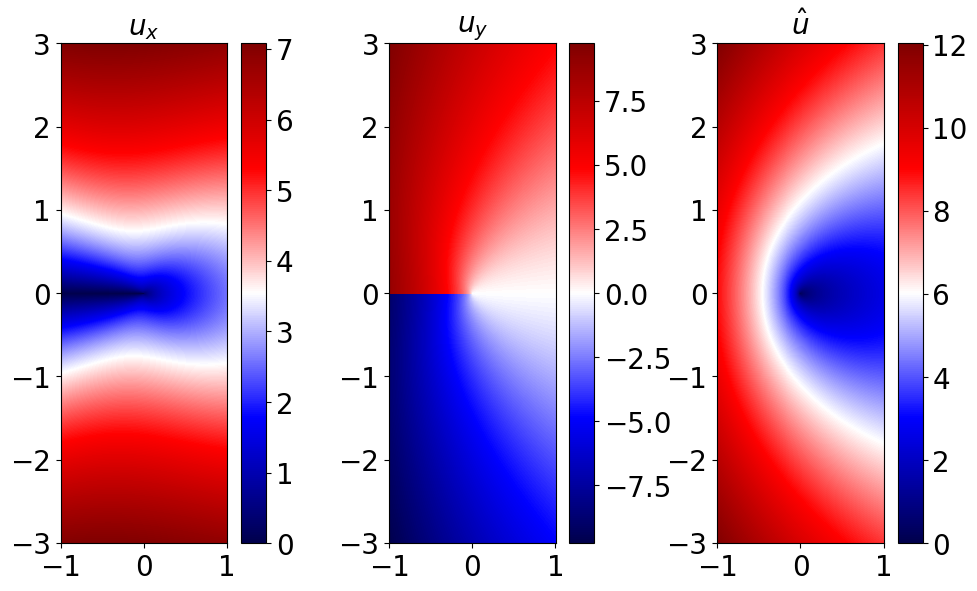

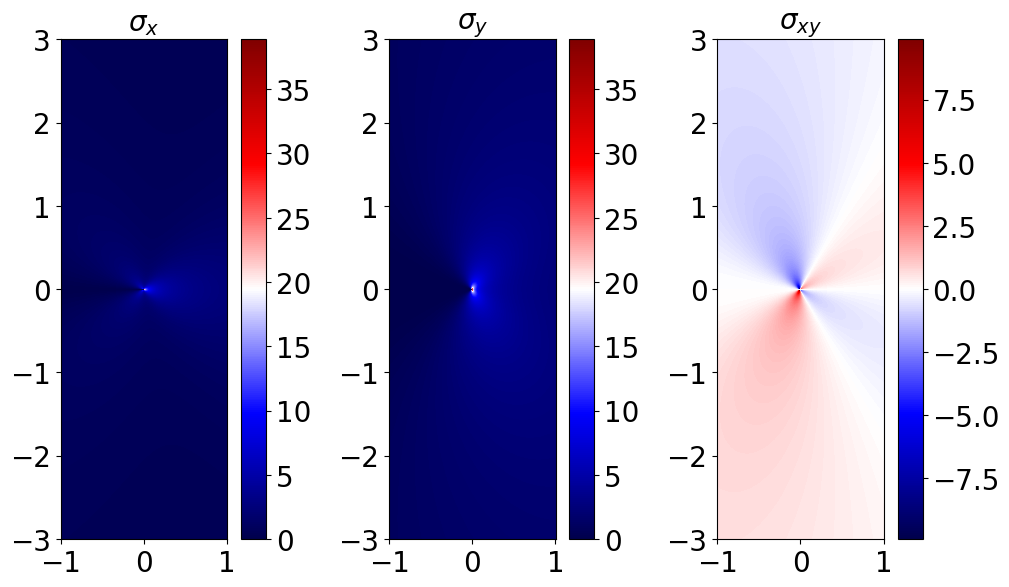

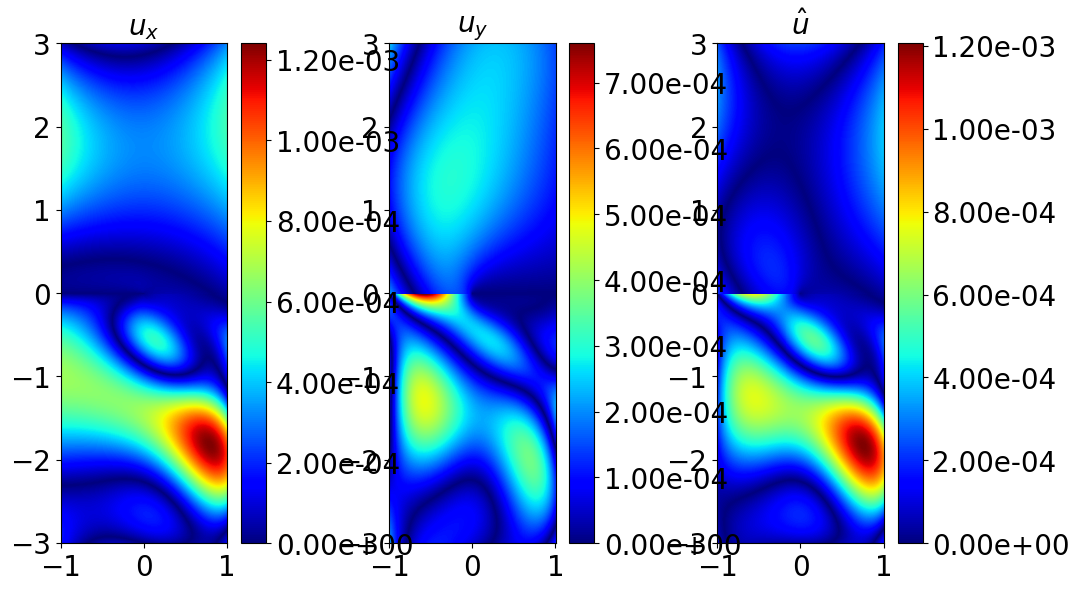

/var/folders/0q/5wrtqh956wv075n93l074rzh0000gn/T/ipykernel_9775/220110718.py:51: RuntimeWarning: invalid value encountered in subtract
  S_total = [abs(Sxx_ext-Sxx), abs(Syy_ext-Syy), abs(Sxy_ext-Sxy)]


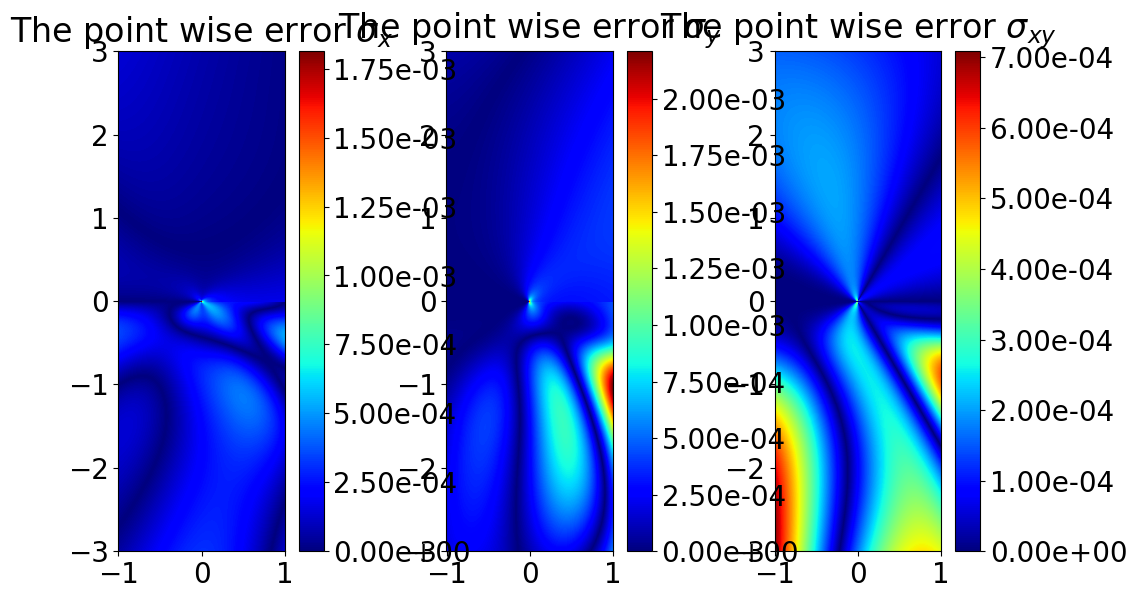

In [21]:
import matplotlib.ticker as ticker
U_total = [Ux, Uy, Uhat]
U_total_name = [r'${u_x}$', r'${u_y}$', r'${\hat{u}}$']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,6.5))
for i,ax in enumerate(axes.flat):
    im = ax.pcolor(X, Y, U_total[i], cmap='seismic')
    ax.set_title(U_total_name[i], fontsize=20)
    ax.set_aspect('equal')
    fig.colorbar(im, ax=ax)
plt.show()

#plt.savefig('Burgers_Solution.pdf', bbox_inches='tight', dpi=300);


S_total = [Sxx, Syy, Sxy]
S_total_name = [
    r'$\sigma_{x}$', 
    r'$\sigma_{y}$', 
    r'$\sigma_{xy}$'
]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,6.5))
for i,ax in enumerate(axes.flat):
    im = ax.pcolor(X, Y, S_total[i], cmap='seismic')
    ax.set_title(S_total_name[i], fontsize=20)
    ax.set_aspect('equal')
    fig.colorbar(im, ax=ax)
plt.show()


# fig.tight_layout()
# plt.show()
error_total = [abs(Ux-Ux_ext), abs(Uy-Uy_ext), abs(Uhat-Uhat_ext)]
error_total_name = [
    r'$u_x$', 
    r'$u_y$', 
    r'$\hat{u}$'
]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,6.5))
for i,ax in enumerate(axes.flat):
    im = ax.pcolor(X, Y, error_total[i], cmap='jet')
    ax.set_title(error_total_name[i], fontsize=20)
    ax.set_aspect('equal')
    cbar = fig.colorbar(im, ax=ax)
    cbar.formatter = ticker.ScalarFormatter(useMathText=True)
    cbar.formatter.set_scientific(True)  # 使用科学记数法
    cbar.formatter = ticker.FormatStrFormatter('%.2e')  # 设置科学记数法并保留两位有效数字
    cbar.ax.yaxis.get_offset_text().set_visible(False)  # 隐藏偏移文本
plt.show()


S_total = [abs(Sxx_ext-Sxx), abs(Syy_ext-Syy), abs(Sxy_ext-Sxy)]
S_total_name = [
    r'The point wise error $\sigma_{x}$', 
    r'The point wise error $\sigma_{y}$', 
    r'The point wise error $\sigma_{xy}$'
]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,6.5))
for i,ax in enumerate(axes.flat):
    im = ax.pcolor(X, Y, S_total[i], cmap='jet')
    ax.set_title(S_total_name[i])
    ax.set_aspect('equal')
    cbar = fig.colorbar(im, ax=ax)
    cbar.formatter = ticker.ScalarFormatter(useMathText=True)
    cbar.formatter.set_scientific(True)  # 使用科学记数法
    cbar.formatter = ticker.FormatStrFormatter('%.2e')  # 设置科学记数法并保留两位有效数字
    cbar.ax.yaxis.get_offset_text().set_visible(False)  # 隐藏偏移文本
plt.show()

/var/folders/0q/5wrtqh956wv075n93l074rzh0000gn/T/ipykernel_9775/2971607849.py:4: RuntimeWarning: invalid value encountered in subtract
  error_total_uS = [abs(Uhat_ext-Uhat), abs(Sxx_ext-Sxx), abs(Syy_ext-Syy), abs(Sxy_ext-Sxy)]


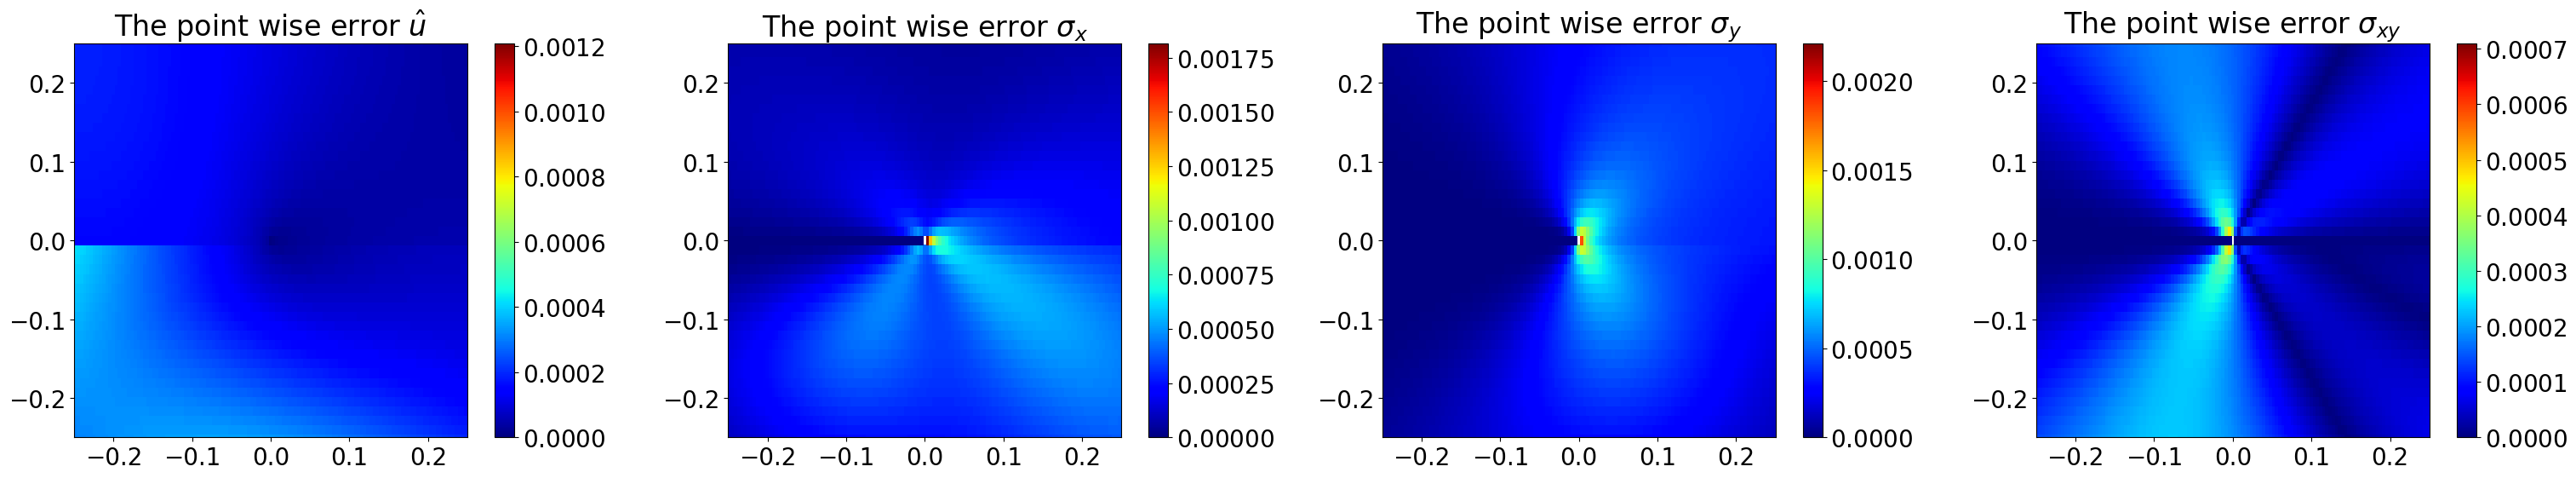

In [28]:
import matplotlib.ticker as ticker
#点点误差局部放大
error_total_uS_name = [ r'The point wise error $\hat{u}$', r'The point wise error $\sigma_{x}$', r'The point wise error $\sigma_{y}$', r'The point wise error $\sigma_{xy}$']
error_total_uS = [abs(Uhat_ext-Uhat), abs(Sxx_ext-Sxx), abs(Syy_ext-Syy), abs(Sxy_ext-Sxy)]
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(38,6))
for i,ax in enumerate(axes.flat):
    im = ax.pcolor(X, Y, error_total_uS[i], cmap='jet')
    ax.set_title(error_total_uS_name[i], fontsize=24)
    ax.set_xlim(-0.25, 0.25)
    ax.set_ylim(-0.25, 0.25)
    ax.set_aspect('equal')
    cbar = fig.colorbar(im, ax=ax)
    cbar.formatter = ticker.ScalarFormatter(useMathText=True)
    #cbar.formatter.set_scientific(True)  # 使用科学记数法
    #cbar.formatter = ticker.FormatStrFormatter('%.1e')  # 设置科学记数法并保留两位有效数字
    cbar.ax.yaxis.get_offset_text().set_visible(False)  # 隐藏偏移文本
plt.show()

/var/folders/0q/5wrtqh956wv075n93l074rzh0000gn/T/ipykernel_9775/264140715.py:20: RuntimeWarning: invalid value encountered in subtract
  error_total_uS = [abs(Uhat_ext - Uhat), abs(Sxx_ext - Sxx), abs(Syy_ext - Syy), abs(Sxy_ext - Sxy)]


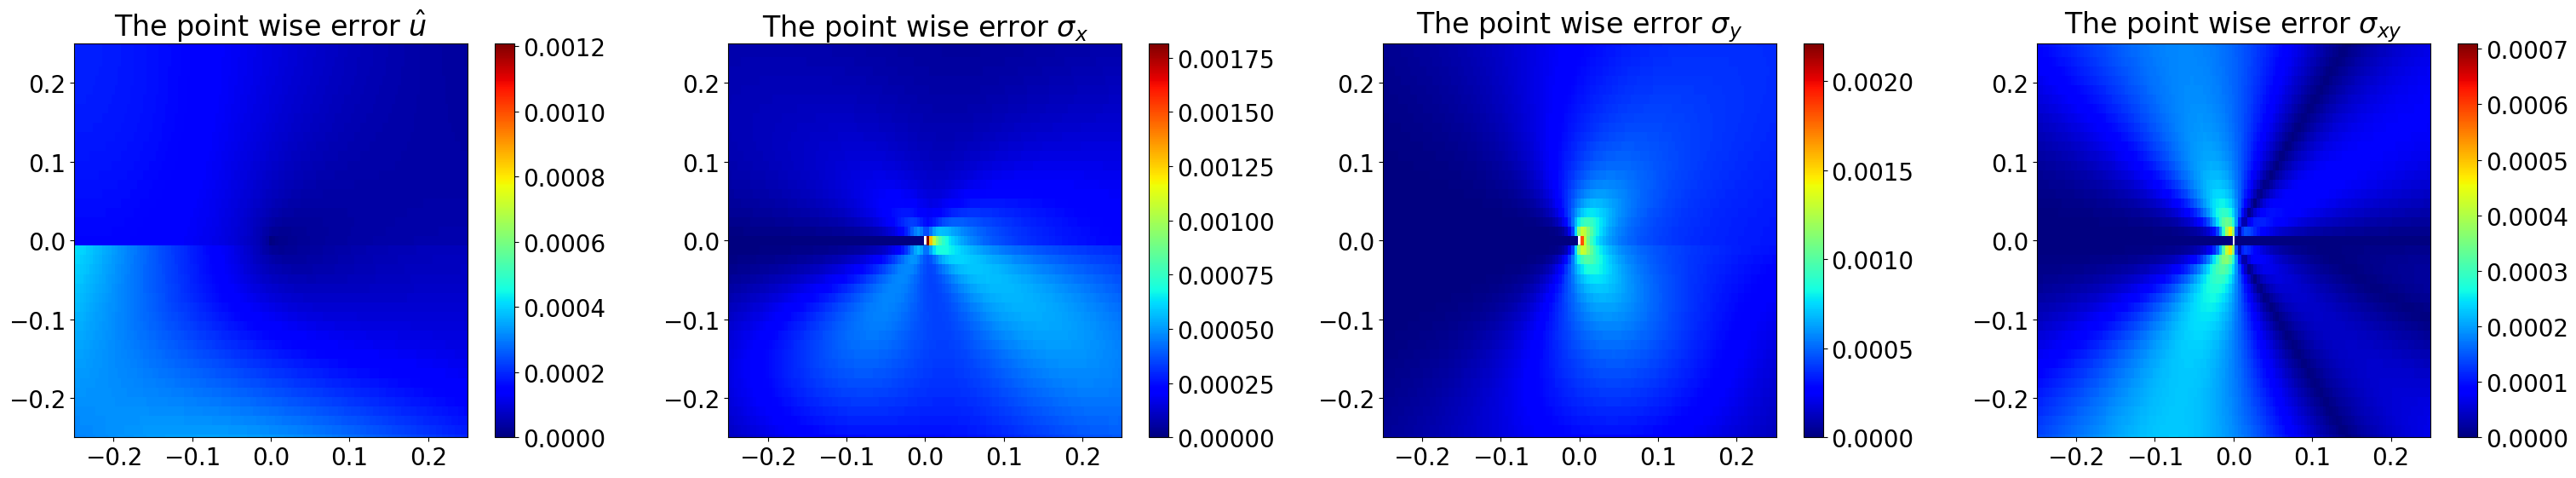

In [37]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FixedLocator

# 点点误差局部放大
ticks = [
    {'ticks': [0, 0.02, 0.04, 0.06, 0.08, 0.1]},
    {'ticks': [0, 0.02, 0.04, 0.06, 0.08, 0.1]},
    {'ticks': [0, 0.02, 0.04, 0.06, 0.08, 0.1]},
    {'ticks': [0, 0.02, 0.04, 0.06, 0.08, 0.1]}
]

error_total_uS_name = [
    r'The point wise error $\hat{u}$',
    r'The point wise error $\sigma_{x}$',
    r'The point wise error $\sigma_{y}$',
    r'The point wise error $\sigma_{xy}$'
]

error_total_uS = [abs(Uhat_ext - Uhat), abs(Sxx_ext - Sxx), abs(Syy_ext - Syy), abs(Sxy_ext - Sxy)]

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(38, 6))

for i, ax in enumerate(axes.flat):
    im = ax.pcolor(X, Y, error_total_uS[i], cmap='jet')
    ax.set_title(error_total_uS_name[i], fontsize=24)
    ax.set_xlim(-0.25, 0.25)
    ax.set_ylim(-0.25, 0.25)
    ax.set_aspect('equal')
    cbar = fig.colorbar(im, ax=ax)
    #cbar.locator = FixedLocator(ticks[i]['ticks'])
    #cbar.formatter = ticker.ScalarFormatter(useMathText=True)
    #cbar.formatter.set_scientific(True)
    #cbar.formatter = ticker.FormatStrFormatter('%.1e')
    cbar.ax.yaxis.get_offset_text().set_visible(False)
    cbar.update_ticks()
plt.show()

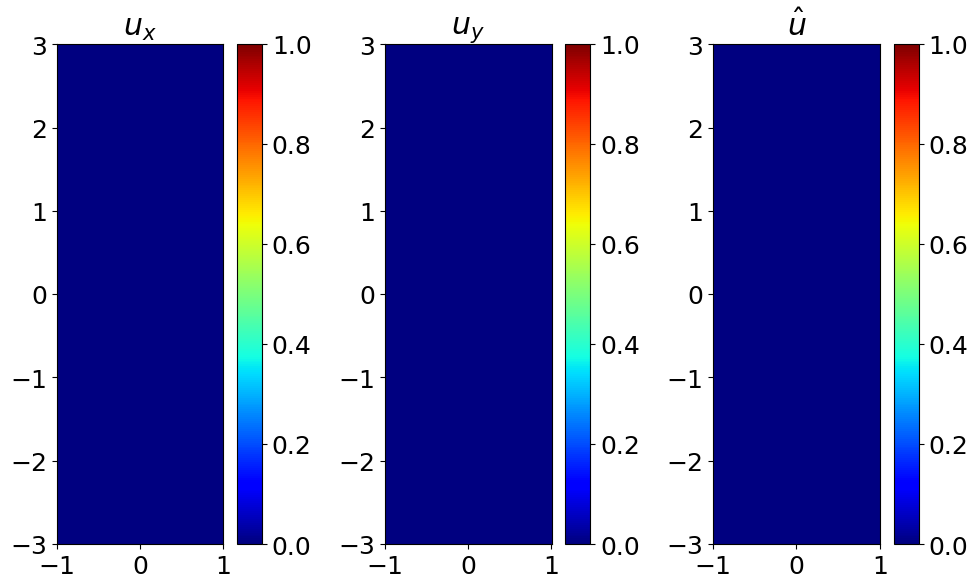

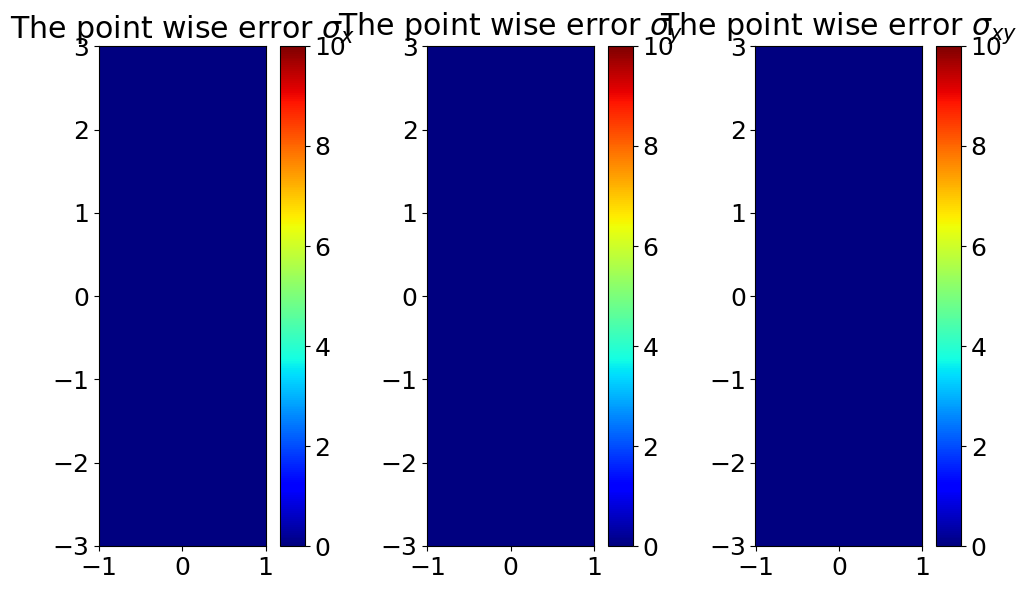

In [27]:

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,6.5))
for i,ax in enumerate(axes.flat):
    im = ax.pcolor(X, Y, error_total[i], cmap='jet',vmin=0, vmax=1)
    ax.set_title(error_total_name[i])
    ax.set_aspect('equal')
    cbar = fig.colorbar(im, ax=ax)
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,6.5))
for i,ax in enumerate(axes.flat):
    im = ax.pcolor(X, Y, S_total[i], cmap='jet',vmin=0, vmax=10)
    ax.set_title(S_total_name[i])
    ax.set_aspect('equal')
    cbar = fig.colorbar(im, ax=ax)
plt.show()

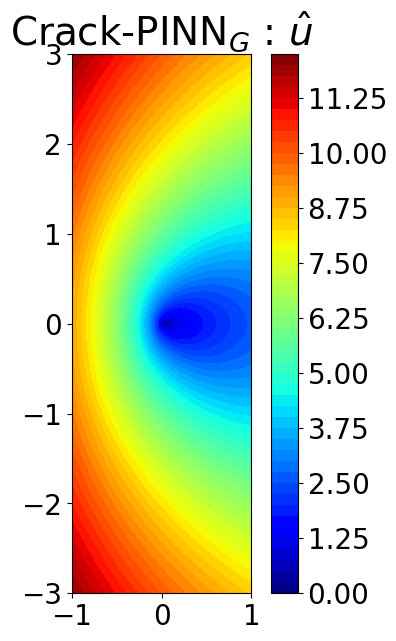

In [22]:
# 第三幅图
fig3, ax3 = plt.subplots(figsize=(5, 7))
im3 = ax3.contourf(X, Y, U_total[2], levels=50, cmap='jet')
ax3.set_title(r'Crack-PINN$_G$ : ${\hat{u}}$', fontsize = 28)
ax3.set_aspect('equal')
fig3.colorbar(im3, ax=ax3)
plt.show()

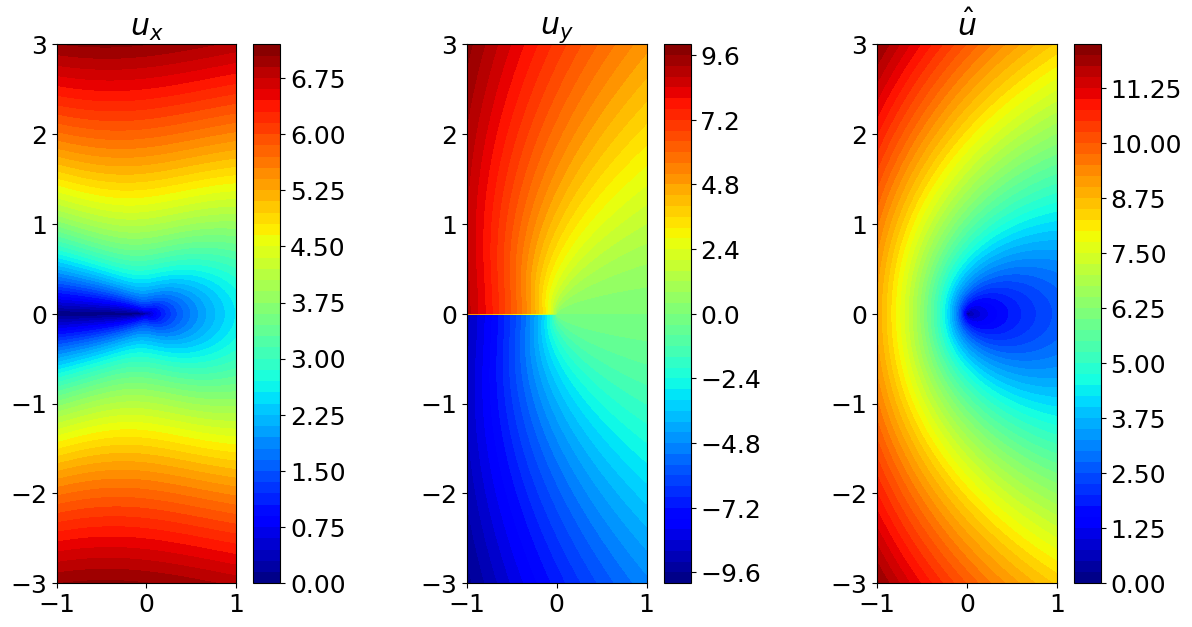

In [44]:

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,7))
colormaps = ['jet', 'jet', 'jet']
for i,ax in enumerate(axes.flat):
    im = ax.contourf(X, Y, U_total[i], levels=50, cmap=colormaps[i])
    ax.set_title(U_total_name[i])
    ax.set_aspect('equal')
    fig.colorbar(im, ax=ax)
plt.show()

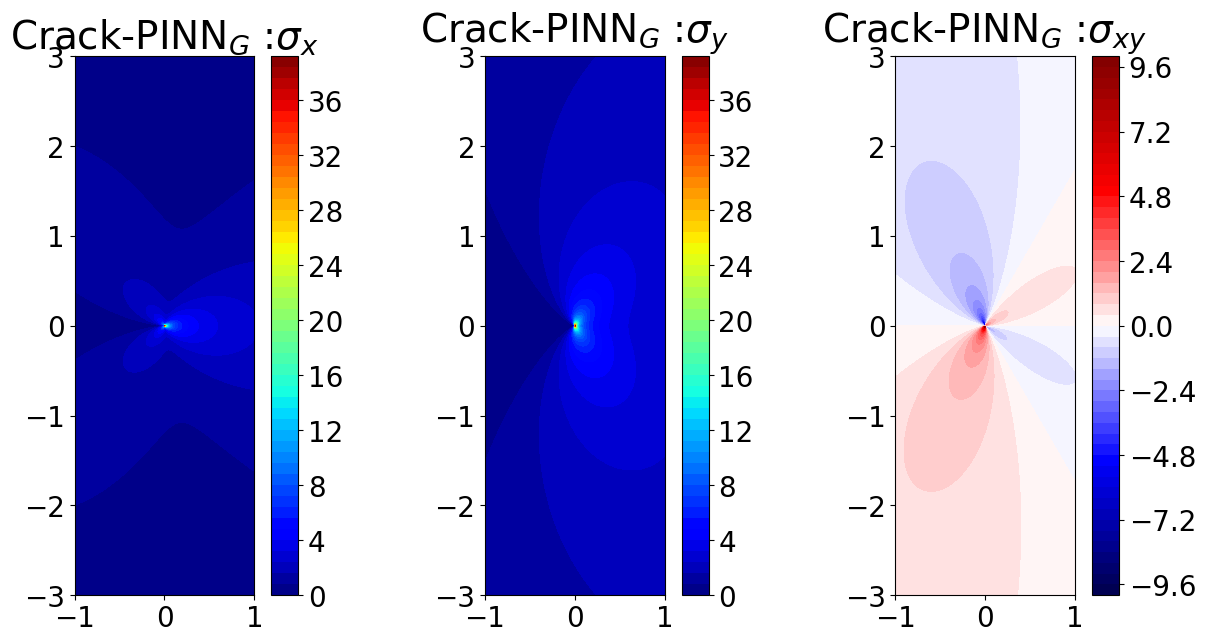

In [24]:
from matplotlib.ticker import ScalarFormatter
S_total = [Sxx, Syy, Sxy]
S_total_name = [
    r'Crack-PINN$_G$ :$\sigma_{x}$', 
    r'Crack-PINN$_G$ :$\sigma_{y}$', 
    r'Crack-PINN$_G$ :$\sigma_{xy}$'
]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 7))

colormaps = ['jet', 'jet', 'seismic']

for i, ax in enumerate(axes.flat):
    # 使用 contourf 绘制填充等高线图，并增加等高线数量
    im = ax.contourf(X, Y, S_total[i], levels=50, cmap=colormaps[i])  # 指定不同的colormap
    ax.set_title(S_total_name[i], fontsize = 28)
    ax.set_aspect('equal')
    fig.colorbar(im, ax=ax)

# 增加图像分辨率
#fig.savefig('enhanced_image.png', dpi=600)  # 保存图像时增加dpi参数

plt.show()

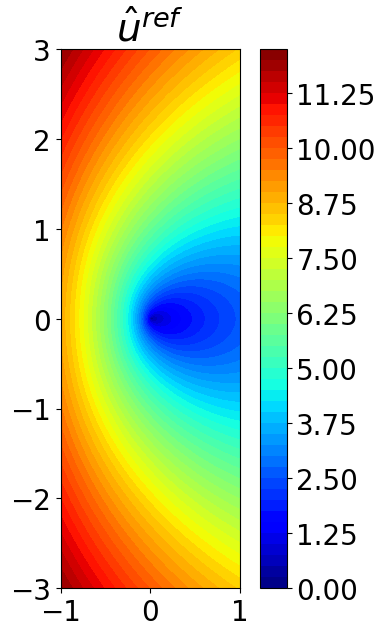

In [23]:
fig1, ax1 = plt.subplots(figsize=(5, 7))  # 调整每幅图的大小
im1 = ax1.contourf(X, Y, Uhat_ext, levels=50, cmap='jet')
ax1.set_title(r'$\hat{u}^{ref}$', fontsize = 28)
ax1.set_aspect('equal')
fig1.colorbar(im1, ax=ax1)
plt.show()

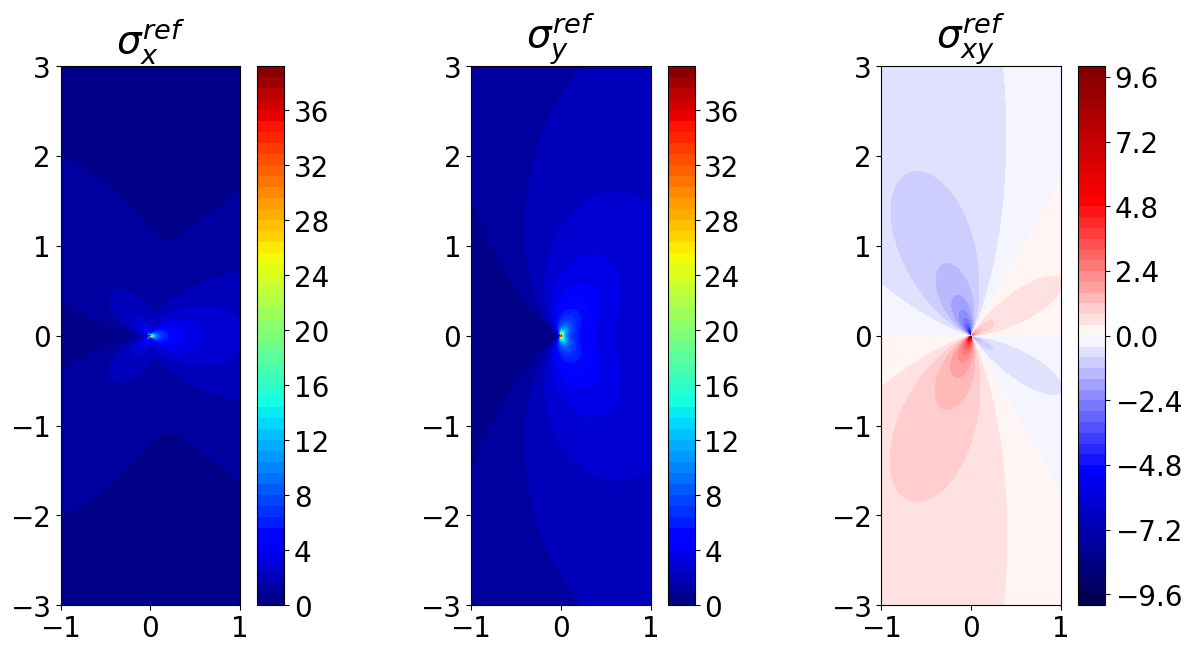

In [25]:
from matplotlib.ticker import ScalarFormatter
S_total_ref = [Sxx_ext, Syy_ext, Sxy_ext]
S_total_name_ref = [
    r'$\sigma_{x}^{ref}$', 
    r'$\sigma_{y}^{ref}$', 
    r'$\sigma_{xy}^{ref}$'
]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 7))

colormaps = ['jet', 'jet', 'seismic']

for i, ax in enumerate(axes.flat):
    # 使用 contourf 绘制填充等高线图，并增加等高线数量
    im = ax.contourf(X, Y, S_total_ref[i], levels=50, cmap=colormaps[i])  # 指定不同的colormap
    ax.set_title(S_total_name_ref[i], fontsize = 28)
    ax.set_aspect('equal')
    fig.colorbar(im, ax=ax)

# 增加图像分辨率
#fig.savefig('enhanced_image.png', dpi=600)  # 保存图像时增加dpi参数

plt.show()

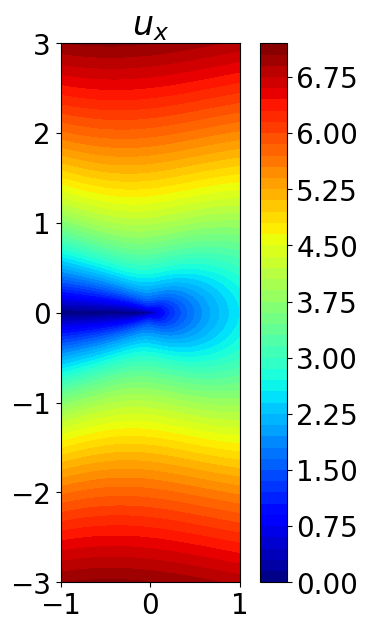

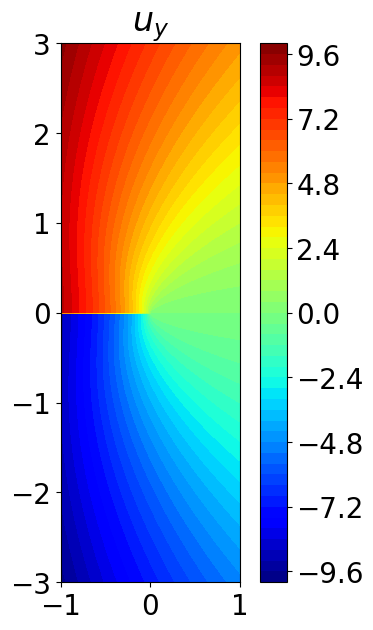

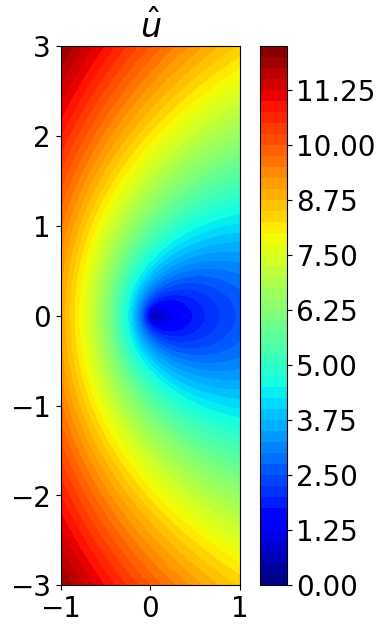

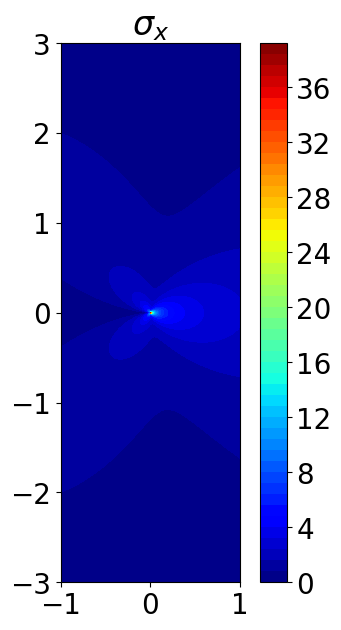

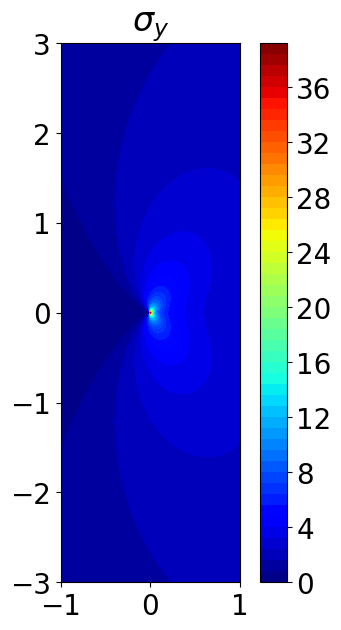

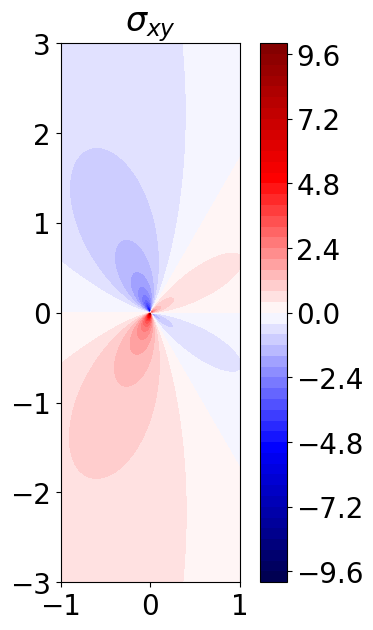

In [22]:
# 第一幅图
fig1, ax1 = plt.subplots(figsize=(5, 7))  # 调整每幅图的大小
im1 = ax1.contourf(X, Y, U_total[0], levels=50, cmap='jet')
ax1.set_title(U_total_name[0])
ax1.set_aspect('equal')
fig1.colorbar(im1, ax=ax1)
plt.show()

# 第二幅图
fig2, ax2 = plt.subplots(figsize=(5, 7))
im2 = ax2.contourf(X, Y, U_total[1], levels=50, cmap='jet')
ax2.set_title(U_total_name[1])
ax2.set_aspect('equal')
fig2.colorbar(im2, ax=ax2)
plt.show()

# 第三幅图
fig3, ax3 = plt.subplots(figsize=(5, 7))
im3 = ax3.contourf(X, Y, U_total[2], levels=50, cmap='jet')
ax3.set_title(U_total_name[2])
ax3.set_aspect('equal')
fig3.colorbar(im3, ax=ax3)
plt.show()

# 第一幅图
fig1, ax1 = plt.subplots(figsize=(5, 7))
im1 = ax1.contourf(X, Y, S_total[0], levels=50, cmap=colormaps[0])
ax1.set_title(S_total_name[0])
ax1.set_aspect('equal')
fig1.colorbar(im1, ax=ax1)
plt.show()

# 第二幅图
fig2, ax2 = plt.subplots(figsize=(5, 7))
im2 = ax2.contourf(X, Y, S_total[1], levels=50, cmap=colormaps[1])
ax2.set_title(S_total_name[1])
ax2.set_aspect('equal')
fig2.colorbar(im2, ax=ax2)
plt.show()

# 第三幅图
fig3, ax3 = plt.subplots(figsize=(5, 7))
im3 = ax3.contourf(X, Y, S_total[2], levels=50, cmap=colormaps[2])
ax3.set_title(S_total_name[2])
ax3.set_aspect('equal')
fig3.colorbar(im3, ax=ax3)
plt.show()

In [ ]:

errorux_1 = np.linalg.norm(Ux-Ux_ext, 2) / np.linalg.norm(Ux_ext,2)
erroruy_1 = np.linalg.norm(Uy-Uy_ext, 2) / np.linalg.norm(Uy_ext,2)
erroruh_1 = np.linalg.norm(Uhat - Uhat_ext, 2) / np.linalg.norm(Uhat_ext,2)
print('Error2 Ux: %e' % (errorux_1))
print('Error2 Uy: %e' % (erroruy_1))
print('Error2 Uhat: %e' % (erroruh_1))


Error2 Ux: 1.026112e-05
Error2 Uy: 8.198146e-06
Error2 Uhat: 4.921283e-06


In [ ]:
if np.any(np.isinf(Sxx)) or np.any(np.isnan(Sxx)):
    #raise ValueError("Matrix Sxx contains inf or NaN values.")
    Sxx = np.nan_to_num(Sxx, nan=0.0, posinf=0.0, neginf=0.0)
if np.any(np.isinf(Sxx_ext)) or np.any(np.isnan(Sxx_ext)):
    #raise ValueError("Matrix Sxx_ext contains inf or NaN values.")
    Sxx_ext = np.nan_to_num(Sxx_ext, nan=0.0, posinf=0.0, neginf=0.0)
if np.any(np.isinf(Syy)) or np.any(np.isnan(Syy)):
    #raise ValueError("Matrix Sxx contains inf or NaN values.")
    Syy = np.nan_to_num(Syy, nan=0.0, posinf=0.0, neginf=0.0)
if np.any(np.isinf(Syy_ext)) or np.any(np.isnan(Syy_ext)):
    #raise ValueError("Matrix Sxx_ext contains inf or NaN values.")
    Syy_ext = np.nan_to_num(Syy_ext, nan=0.0, posinf=0.0, neginf=0.0)

if np.any(np.isinf(Sxy)) or np.any(np.isnan(Sxy)):
    #raise ValueError("Matrix Sxx contains inf or NaN values.")
    Sxy = np.nan_to_num(Sxy, nan=0.0, posinf=0.0, neginf=0.0)

if np.any(np.isinf(Sxy_ext)) or np.any(np.isnan(Sxy_ext)):
    #raise ValueError("Matrix Sxx_ext contains inf or NaN values.")
    Sxy_ext = np.nan_to_num(Sxy_ext, nan=0.0, posinf=0.0, neginf=0.0)
    errorSxx_1 = np.linalg.norm(Sxx-Sxx_ext, 2) / np.linalg.norm(Sxx_ext,2)
errorSyy_1 = np.linalg.norm(Syy-Syy_ext, 2) / np.linalg.norm(Syy_ext,2)
errorSxy_1 = np.linalg.norm(Sxy - Sxy_ext, 2) / np.linalg.norm(Sxy_ext,2)
print('Error2 Sxx: %e' % (errorSxx_1))
print('Error2 Syy: %e' % (errorSyy_1))
print('Error2 Sxy: %e' % (errorSxy_1))

Error2 Sxx: 3.849012e-05
Error2 Syy: 2.267049e-05
Error2 Sxy: 2.415067e-05


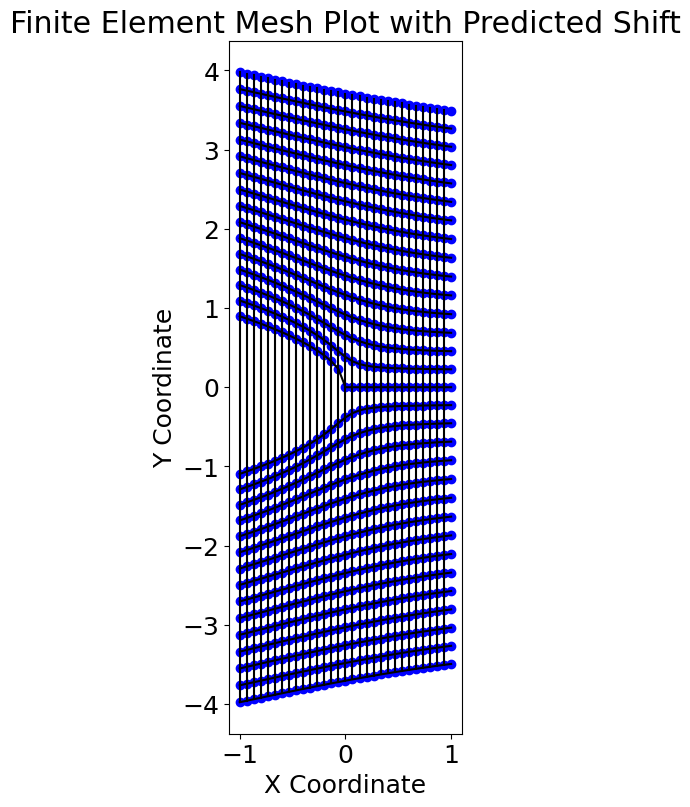

In [46]:
# Set up meshgrid
N = 30
xspace = np.linspace(lb[0], ub[0], N + 1)
yspace = np.linspace(lb[1], ub[1], N + 1)
# # 移除Y=0的点
# mask = yspace != 0
# yspace = yspace[mask]
X, Y = np.meshgrid(xspace, yspace)
Xgrid = np.vstack([X.flatten(),Y.flatten()]).T
Xgrid_tensor = torch.tensor(Xgrid, dtype=DTYPE)
x_t, y_t, x_f, y_f, labels_t, labels_f = split_tensors_by_condition(Xgrid_tensor[:, 0], Xgrid_tensor[:, 1], None,lambda y:y < 0)

# Determine predictions of u(t, x)
Ux_pred_t, Uy_pred_t, Sxx_pred_t, Syy_pred_t, Sxy_pred_t = modelMNN(torch.hstack([x_t, y_t]), labels_t)
Ux_pred_f, Uy_pred_f, Sxx_pred_f, Syy_pred_f, Sxy_pred_f = modelMNN(torch.hstack([x_f, y_f]), labels_f)

Ux_pred_t = compute_tipregion_u_x(Ux_pred_t, x_t, y_t)
Ux_pred_f = compute_tipregion_u_x(Ux_pred_f, x_f, y_f)

Uy_pred_t = compute_tipregion_u_y(Uy_pred_t, x_t, y_t)
Uy_pred_f = compute_tipregion_u_y(Uy_pred_f, x_f, y_f)

Sxx_pred_t = compute_tipregion_Sxx(Sxx_pred_t, x_t, y_t)
Sxx_pred_f = compute_tipregion_Sxx(Sxx_pred_f, x_f, y_f)

Syy_pred_t = compute_tipregion_Syy(Syy_pred_t, x_t, y_t)
Syy_pred_f = compute_tipregion_Syy(Syy_pred_f, x_f, y_f)

Sxy_pred_t = compute_tipregion_Sxy(Sxy_pred_t, x_t, y_t)
Sxy_pred_f = compute_tipregion_Sxy(Sxy_pred_f, x_f, y_f)

ux_pred = torch.cat((Ux_pred_t, Ux_pred_f), dim=0)
uy_pred = torch.cat((Uy_pred_t, Uy_pred_f), dim=0)


# 将位移应用到网格点
#X += ux_pred.detach().numpy().reshape(X.shape)
Y += uy_pred.detach().numpy().reshape(Y.shape)*1e-1

# 绘制网格线
plt.figure(figsize=(3, 9))
for i in range(N):
    plt.plot(X[i, :], Y[i, :], 'k-')  # 垂直线
    plt.plot(X[:, i], Y[:, i], 'k-')  # 水平线

# 绘制网格点
plt.scatter(X.flatten(), Y.flatten(), color='blue')

# 设置图表的标题和标签
plt.title('Finite Element Mesh Plot with Predicted Shift')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# 显示图表
plt.show()

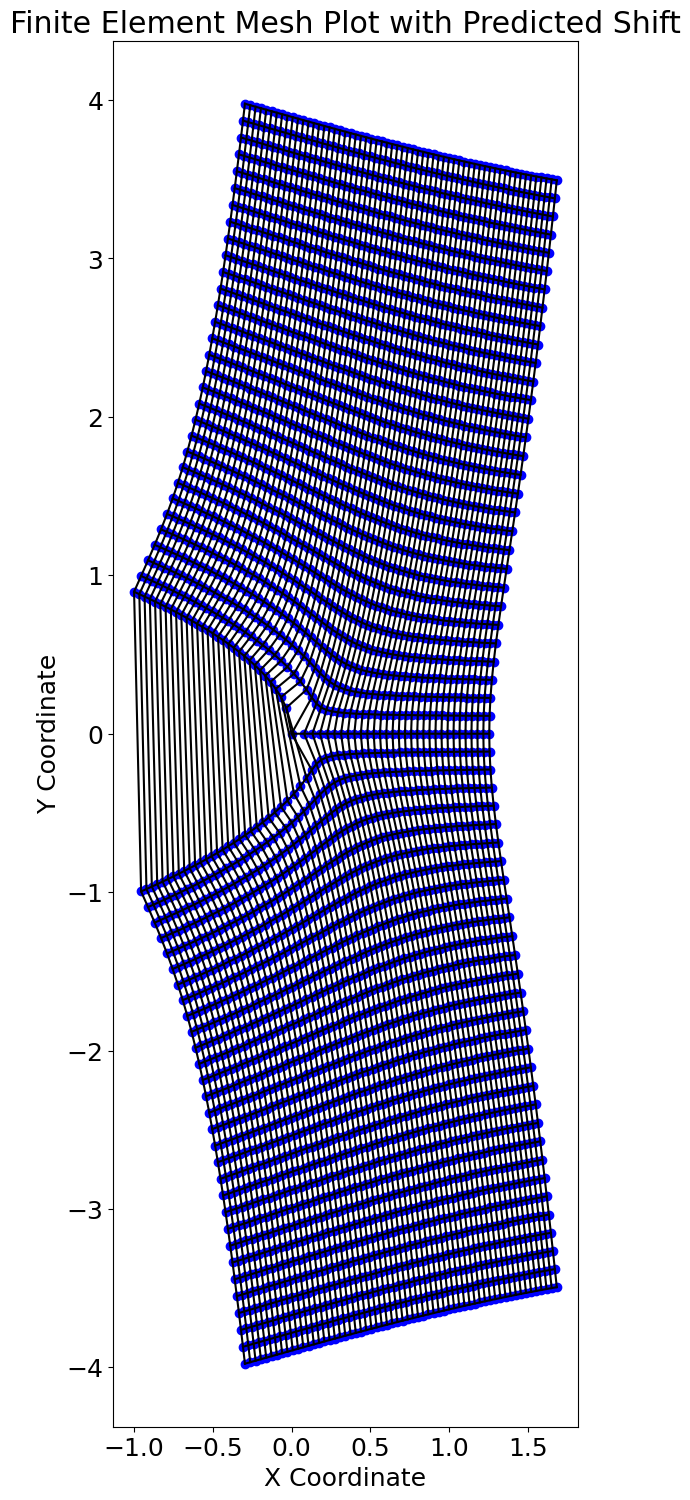

In [47]:
# Set up meshgrid
N = 60
xspace = np.linspace(lb[0], ub[0], N + 1)
yspace = np.linspace(lb[1], ub[1], N + 1)
# # 移除Y=0的点
# mask = yspace != 0
# yspace = yspace[mask]
X, Y = np.meshgrid(xspace, yspace)
Xgrid = np.vstack([X.flatten(),Y.flatten()]).T
Xgrid_tensor = torch.tensor(Xgrid, dtype=DTYPE)
x_t, y_t, x_f, y_f, labels_t, labels_f = split_tensors_by_condition(Xgrid_tensor[:, 0], Xgrid_tensor[:, 1], None,lambda y:y < 0)

# Determine predictions of u(t, x)
Ux_pred_t, Uy_pred_t, Sxx_pred_t, Syy_pred_t, Sxy_pred_t = modelMNN(torch.hstack([x_t, y_t]), labels_t)
Ux_pred_f, Uy_pred_f, Sxx_pred_f, Syy_pred_f, Sxy_pred_f = modelMNN(torch.hstack([x_f, y_f]), labels_f)

Ux_pred_t = compute_tipregion_u_x(Ux_pred_t, x_t, y_t)
Ux_pred_f = compute_tipregion_u_x(Ux_pred_f, x_f, y_f)

Uy_pred_t = compute_tipregion_u_y(Uy_pred_t, x_t, y_t)
Uy_pred_f = compute_tipregion_u_y(Uy_pred_f, x_f, y_f)

Sxx_pred_t = compute_tipregion_Sxx(Sxx_pred_t, x_t, y_t)
Sxx_pred_f = compute_tipregion_Sxx(Sxx_pred_f, x_f, y_f)

Syy_pred_t = compute_tipregion_Syy(Syy_pred_t, x_t, y_t)
Syy_pred_f = compute_tipregion_Syy(Syy_pred_f, x_f, y_f)

Sxy_pred_t = compute_tipregion_Sxy(Sxy_pred_t, x_t, y_t)
Sxy_pred_f = compute_tipregion_Sxy(Sxy_pred_f, x_f, y_f)

ux_pred = torch.cat((Ux_pred_t, Ux_pred_f), dim=0)
uy_pred = torch.cat((Uy_pred_t, Uy_pred_f), dim=0)


# 将位移应用到网格点
X += ux_pred.detach().numpy().reshape(X.shape)*1e-1
Y += uy_pred.detach().numpy().reshape(Y.shape)*1e-1

# 绘制网格线
plt.figure(figsize=(6, 18))
for i in range(X.shape[1]):  # 使用 X.shape[1] 来确保包括最后一列
    plt.plot(X[:, i], Y[:, i], 'k-')  # 垂直线
for i in range(X.shape[0]):  # 使用 X.shape[0] 来确保包括最后一行
    plt.plot(X[i, :], Y[i, :], 'k-')  # 水平线

# 绘制网格点
plt.scatter(X.flatten(), Y.flatten(), color='blue')

# 设置图表的标题和标签
plt.title('Finite Element Mesh Plot with Predicted Shift')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# 显示图表
plt.show()

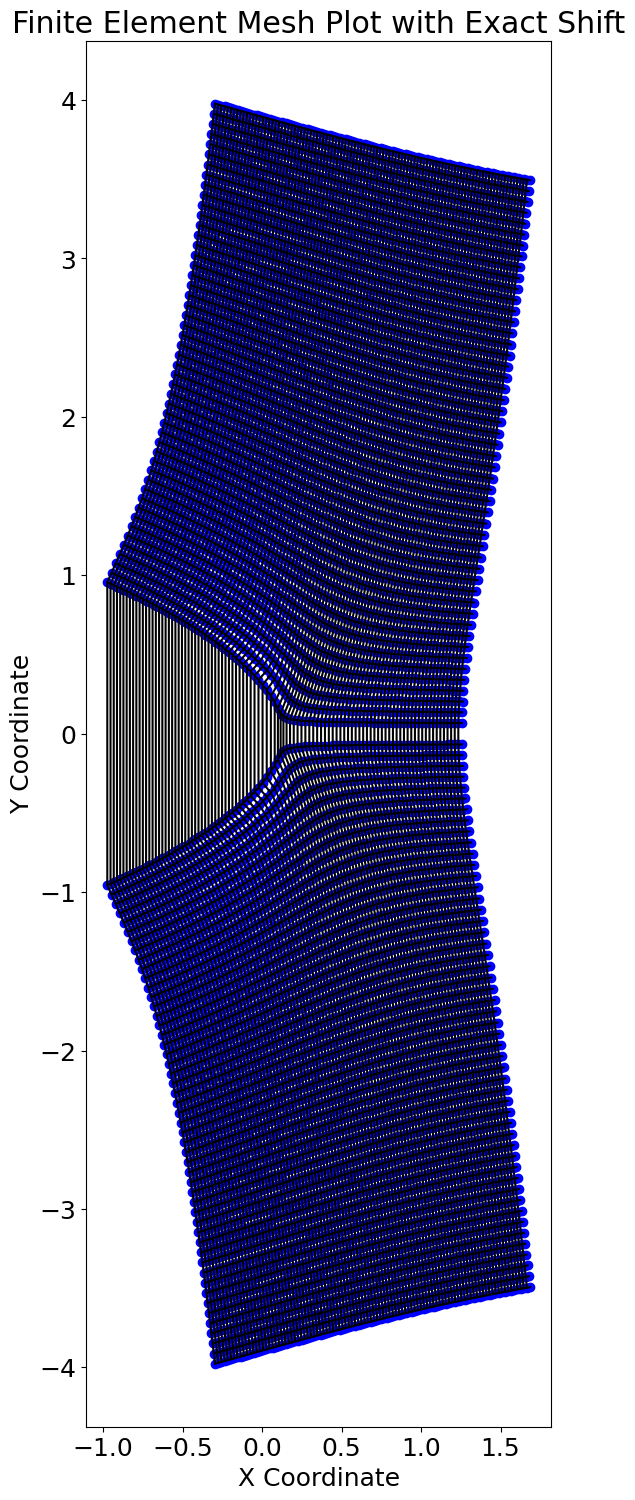

In [37]:
# Set up meshgrid
N = 100
xspace = np.linspace(lb[0], ub[0], N + 1)
yspace = np.linspace(lb[1], ub[1], N + 1)
# 移除Y=0的点
mask = yspace != 0
yspace = yspace[mask]
X, Y = np.meshgrid(xspace, yspace)

# 将 X 和 Y 转换为 PyTorch 张量
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)

# 计算外部位移
ux_ext = u_x_ext(X_tensor, Y_tensor).detach().numpy() * 1e-1
uy_ext = u_y_ext(X_tensor, Y_tensor).detach().numpy() * 1e-1  # 假设 uy_ext 与 u_x_ext 相同，需要根据实际情况调整

# 将位移应用到网格点
X += ux_ext
Y += uy_ext


# 绘制网格线
plt.figure(figsize=(6, 18))
for i in range(N):
    plt.plot(X[i, :], Y[i, :], 'k-')  # 垂直线
    plt.plot(X[:, i], Y[:, i], 'k-')  # 水平线

# 绘制网格点
plt.scatter(X.flatten(), Y.flatten(), color='blue')

# 设置图表的标题和标签
plt.title('Finite Element Mesh Plot with Exact Shift')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# 显示图表
plt.show()
